## Homework 4
October 9, 2022<br>
Vivian Lin<br>
ID: 6043749830<br>
Dr. Mohammad Rajati

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, multilabel_confusion_matrix
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.naive_bayes import GaussianNB, MultinomialNB

Data processing from Homework3 (same code):

In [2]:
# Read all 7 csv files in bending1 folder.
bending1 = ["dataset" + str(x) for x in range(1, 8)]
b1_df = []

for i in range(len(bending1)):
    temp = pd.read_csv("../data/AReM/bending1/" + bending1[i] + ".csv", skiprows=3, header=1)
    temp.rename(columns={"# Columns: time": "time"}, inplace=True)
    temp["type"] = "bending"
    if temp.isnull().values.any() or temp.shape[0] != 480:
        print(f"Data cleaning required in bending1: {bending1[i]}")
    b1_df.append(temp)

# Read all 6 csv files in bending1 folder.
bending2 = ["dataset" + str(x) for x in range(1, 7)]
b2_df = []

for i in range(len(bending2)):
    temp = pd.read_csv("../data/AReM/bending2/" + bending2[i] + ".csv", skiprows=3, header=1)
    temp.rename(columns={"# Columns: time": "time"}, inplace=True)
    temp["type"] = "bending"
    if temp.isnull().values.any() or temp.shape[0] != 480:
        print(f"Data cleaning required in bending2: {bending2[i]}")
    b2_df.append(temp)

# Read all 15 csv files in cycling folder.
# Manual data cleaning to remove extra comma at end of cycling dataset9 and dataset14.
cycling = ["dataset" + str(x) for x in range(1, 16)]
c_df = []

for i in range(len(cycling)):
    temp = pd.read_csv("../data/AReM/cycling/" + cycling[i] + ".csv", skiprows=3, header=1)
    temp.rename(columns={"# Columns: time": "time"}, inplace=True)
    temp["type"] = "cycling"
    if temp.isnull().values.any() or temp.shape[0] != 480:
        print(f"Data cleaning required in cycling: {cycling[i]}")
    c_df.append(temp)

# Read all 15 csv files in lying folder.
lying = ["dataset" + str(x) for x in range(1, 16)]
l_df = []

for i in range(len(lying)):
    temp = pd.read_csv("../data/AReM/lying/" + lying[i] + ".csv", skiprows=3, header=1)
    temp.rename(columns={"# Columns: time": "time"}, inplace=True)
    temp["type"] = "lying"
    if temp.isnull().values.any() or temp.shape[0] != 480:
        print(f"Data cleaning required in lying: {lying[i]}")
    l_df.append(temp)

# Read all 15 csv files in sitting folder.
sitting = ["dataset" + str(x) for x in range(1, 16)]
si_df = []

for i in range(len(sitting)):
    temp = pd.read_csv("../data/AReM/sitting/" + sitting[i] + ".csv", skiprows=3, header=1)
    temp.rename(columns={"# Columns: time": "time"}, inplace=True)
    temp["type"] = "sitting"
    if temp.isnull().values.any() or temp.shape[0] != 480:
        print(f"Data cleaning required in sitting: {sitting[i]}")
    si_df.append(temp)

# Read all 15 csv files in standing folder.
standing = ["dataset" + str(x) for x in range(1, 16)]
st_df = []

for i in range(len(standing)):
    temp = pd.read_csv("../data/AReM/standing/" + standing[i] + ".csv", skiprows=3, header=1)
    temp.rename(columns={"# Columns: time": "time"}, inplace=True)
    temp["type"] = "standing"
    if temp.isnull().values.any() or temp.shape[0] != 480:
        print(f"Data cleaning required in standing: {standing[i]}")
    st_df.append(temp)

# Read all 15 csv files in walking folder.
walking = ["dataset" + str(x) for x in range(1, 16)]
w_df = []

for i in range(len(walking)):
    temp = pd.read_csv("../data/AReM/walking/" + walking[i] + ".csv", skiprows=3, header=1)
    temp.rename(columns={"# Columns: time": "time"}, inplace=True)
    temp["type"] = "walking"
    if temp.isnull().values.any() or temp.shape[0] != 480:
        print(f"Data cleaning required in walking: {walking[i]}")
    w_df.append(temp)

# Data clean for bending2 dataset4
# Manually cleaned up bending2 dataset4 such that the header row matches the rest of the data (white-space separated).
temp = pd.read_csv("../data/AReM/bending2/dataset4.csv", delim_whitespace=True)
temp.rename(columns={"# Columns: time": "time"}, inplace=True)
temp["type"] = "bending"
b2_df[3] = temp
# Data clean is not required for sitting dataset8 since it is missing one row, making this the only dataframe with 479 rows instead of 480.

test = []
train = []

# For bending1 and bending2, only dataset1 and dataset2 are test data.
df_name = [b1_df, b2_df]
dataset = [0, 1]
for name in df_name:
    for i in range(len(name)):
        if i in dataset:
            test.append(name[i])
        else:
            train.append(name[i])

# For the rest, dataset1, dataset2, and dataset3 are test data.
df_name = [c_df, l_df, si_df, st_df, w_df]
dataset = [0, 1, 2]
for name in df_name:
    for i in range(len(name)):
        if i in dataset:
            test.append(name[i])
        else:
            train.append(name[i])

print(len(test), len(train))

Data cleaning required in bending2: dataset4
Data cleaning required in sitting: dataset8
19 69


Function definitions:

In [3]:
def break_time_series(df, num_splits):
    """
    Function breaks a time series instance into approximately equal length time series.
    
    Parameters:
    df (DataFrame): Time series dataframe to be broken into equal length.
    num_splits (int): Number of approximately equal length time series.
    
    Returns:
    DataFrame with broken time series as added features.
    """
    temp = df
    chunks = np.array_split(temp, num_splits)
    df_list = []
    for i in range(num_splits):        
        # Prevent 'time' and 'type' columns from repeating in the dataframe.
        if i > 0:
            chunks[i].drop(['time', 'type'], axis=1, inplace=True)
        splitted = chunks[i]
        splitted.reset_index(drop=True, inplace=True)
        df_list.append(splitted)
    res = pd.concat(df_list, axis=1)
    return res

In [4]:
def extract_features_dataframe(dfs, split, series_num, train=True):
    """
    Function extracts the mean, median, and standard deviation of selected time series and changes class labels to 0 (other activities) and 1 (bending).
    
    Parameters:
    dfs (list): List of time series dataframes.
    split (int): Number of chunks the time series has been broken down into.
    series_num (list): List of numbers representing the time series to be considered. For example, 'avg_rss12' = 1, 'var_rss12' = 2, 'avg_rss13' = 3, 'var_rss13' = 4, 'avg_rss23' = 5, 'var_rss23' = 6.
    
    Returns:
    DataFrame with broken time series as added features.
    """
    mean = []
    median = []
    stdev = []
    type_ls = []
    number = deepcopy(series_num)

    # Include all features after the time series has been broken down.
    for i in range(1, split):
        series_num.extend(list(map(lambda x: x + 6 * i, number)))

    # Extract the selected features (mean, median, and standard deviation) from time series.
    for i in range(len(dfs)):
        if dfs[i]['type'][0] == 'bending':
            # Bending will be 1.
            type_ls.append(1)
        else:
            # Other activities will be 0.
            type_ls.append(0)

        m_temp = dfs[i].describe().iloc[1, series_num]
        m_temp.index = [f'mean{x}' for x in series_num]
        mean.append(m_temp.to_dict())

        s_temp = dfs[i].describe().iloc[2, series_num]
        s_temp.index = [f'std{x}' for x in series_num]
        stdev.append(s_temp.to_dict())
        
        md_temp = dfs[i].describe().iloc[5, series_num]
        md_temp.index = [f'med{x}' for x in series_num]
        median.append(md_temp.to_dict())

    # Create the dataframe.
    mean_df = pd.DataFrame.from_dict(mean)
    std_df = pd.DataFrame.from_dict(stdev)
    med_df = pd.DataFrame.from_dict(median)

    if train:
        instance = [x for x in range(1, 70)]
    else:
        instance = [x for x in range(1, 20)]

    res_df = pd.DataFrame({'instance': instance, 'type': type_ls})
    res_df = pd.concat([res_df, mean_df, std_df, med_df], axis=1)
    res_df.set_index('instance', inplace=True)
    return res_df

In [5]:
def multiclass_extract_features_dataframe(dfs, split, series_num, train=True):
    """
    Function extracts the mean, median, and standard deviation of selected time series, but keeps all class labels.
    
    Parameters:
    dfs (list): List of time series dataframes.
    split (int): Number of chunks the time series has been broken down into.
    series_num (list): List of numbers representing the time series to be considered. For example, 'avg_rss12' = 1, 'var_rss12' = 2, 'avg_rss13' = 3, 'var_rss13' = 4, 'avg_rss23' = 5, 'var_rss23' = 6.
    
    Returns:
    DataFrame with broken time series as added features.
    """
    mean = []
    median = []
    stdev = []
    type_ls = []
    number = deepcopy(series_num)

    # Include all features after the time series has been broken down.
    for i in range(1, split):
        series_num.extend(list(map(lambda x: x + 6 * i, number)))

    # Extract the selected features (mean, median, and standard deviation) from time series.
    for i in range(len(dfs)):
        # Only difference between function extract_features_dataframe and this function is the type being appended.
        # This function keeps all classes.
        if dfs[i]['type'][0] == 'bending':
            type_ls.append(1)
        elif dfs[i]['type'][0] == 'cycling':
            type_ls.append(2)
        elif dfs[i]['type'][0] == 'lying':
            type_ls.append(3)
        elif dfs[i]['type'][0] == 'sitting':
            type_ls.append(4)
        elif dfs[i]['type'][0] == 'standing':
            type_ls.append(5)
        elif dfs[i]['type'][0] == 'walking':
            type_ls.append(6)

        m_temp = dfs[i].describe().iloc[1, series_num]
        m_temp.index = [f'mean{x}' for x in series_num]
        mean.append(m_temp.to_dict())

        s_temp = dfs[i].describe().iloc[2, series_num]
        s_temp.index = [f'std{x}' for x in series_num]
        stdev.append(s_temp.to_dict())
        
        md_temp = dfs[i].describe().iloc[5, series_num]
        md_temp.index = [f'med{x}' for x in series_num]
        median.append(md_temp.to_dict())

    # Create the dataframe.
    mean_df = pd.DataFrame.from_dict(mean)
    std_df = pd.DataFrame.from_dict(stdev)
    med_df = pd.DataFrame.from_dict(median)

    if train:
        instance = [x for x in range(1, 70)]
    else:
        instance = [x for x in range(1, 20)]

    res_df = pd.DataFrame({'instance': instance, 'type': type_ls})
    res_df = pd.concat([res_df, mean_df, std_df, med_df], axis=1)
    res_df.set_index('instance', inplace=True)
    return res_df

In [6]:
def stratified_rfecv(model, df_dict):
    """
    Function runs cross validation at the step of featrue selection using StratifiedKFold to account for class inbalance. To help select the best number of splits to break the time series.
    
    Parameters:
    model (estimator): Model to be fitted (ie. LogisticRegression()).
    df_dict (dict): Dictionary of dataframes with keys being the number of splits and values being the dataframe after split.
    
    """
    
    # Select featrues using backward feature selection and use 5-fold stratified cross validation to find best number of splits for time series.
    res_dict = {}
    for l in range(1, 21):
        X = df_dict[l].drop(['type'], axis=1)
        y = df_dict[l]['type']
        selector = RFECV(model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
        selector = selector.fit(X=X, y=y)
        res_dict[l] = max(selector.cv_results_['mean_test_score'])
    
    print(res_dict)

    # Find the best number of splits for time series.
    max_val = max(res_dict.values())
    max_key = []
    for key, val in res_dict.items():
        if val == max_val:
            max_key.append(key)
    
    print(f"All of the following splits has the good mean_test_score: {max_key}.")
    print(f"Choosing the smallest l from the list, splitting data into {max(res_dict, key=res_dict.get)} has maximum mean_test_score at {max_val}.")

    return max_key[0]

In [7]:
def opt_stratified_rfecv(model, df_dict, optimal_split):
    """
    Function runs cross validation at the step of featrue selection using StratifiedKFold to account for class inbalance on the optimal number of splits (l) as determined previously.
    
    Parameters:
    model (estimator): Model to be fitted (ie. LogisticRegression()).
    df_dict (dict): Dictionary of dataframes with keys being the number of splits and values being the dataframe after split.
    optimal_split(int): Optimal number of splits to break the time series.
    
    Returns:
    List selected_feats with features selected by backward selection rfecv.
    """
    
    # Select featrues using backward feature selection and use 5-fold stratified cross validation to find best number of splits for time series.
    X = df_dict[optimal_split].drop(['type'], axis=1)
    y = df_dict[optimal_split]['type']
    selector = RFECV(model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
    selector = selector.fit(X=X, y=y)
    print(f"Optimal number of features is: {selector.n_features_} and the features selected are the following: {selector.get_support(indices=True)}.")
    print(f"In other words, best (l,p) pair is ({optimal_split}, {selector.n_features_}).")

    # Find the best number of splits for time series.
    selected = []
    for i in selector.get_support(indices=True):
        selected.append(X.columns[i])

    print(f"Selected features: {selected}")
    return selected

In [8]:
def plot_ROC(X, y, data_name, model):
    """
    Function plots the ROC curve with AUC on the plot label.
    
    Parameters:
    X (DataFrame): X_train or X_test on selected features.
    y (DataFrame): y_train or y_test on selected features.
    data_name(str): Name of the plot that follows "ROC Curve for".
    
    """
    y_score = model.predict_proba(X)[:,1]
    fpr, tpr, threshold = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve and the AUC.
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc}')
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {data_name}")
    plt.legend()
    plt.show()
    return

<b>2) Time Series Classification Part 2: Binary and Multiclass Classification<br>
2ai) Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. The three features I identified in 1civ) of Homework3 were mean, median and standard deviation. </b>

In [9]:
mean = []
median = []
stdev = []
type_ls = []

for i in range(len(train)):
    if train[i]['type'][0] == 'bending':
        # Bending will be 1.
        type_ls.append(1)
    else:
        # Other activities will be 0.
        type_ls.append(0)
    mean.append(train[i].describe().iloc[1,[1,2,6]].to_dict())
    stdev.append(train[i].describe().iloc[2,[1,2,6]].to_dict())
    median.append(train[i].describe().iloc[5,[1,2,6]].to_dict())

mean_df = pd.DataFrame.from_dict(mean)
mean_df.rename(columns={'avg_rss12': 'mean1', 'var_rss12': 'mean2', 'var_rss23': 'mean6'}, inplace=True)
std_df = pd.DataFrame.from_dict(stdev)
std_df.rename(columns={'avg_rss12': 'std1', 'var_rss12': 'std2', 'var_rss23': 'std6'}, inplace=True)
med_df = pd.DataFrame.from_dict(median)
med_df.rename(columns={'avg_rss12': 'med1', 'var_rss12': 'med2', 'var_rss23': 'med6'}, inplace=True)

instance = [x for x in range(1, 70)]

mms_df = pd.DataFrame({'instance': instance, 'type': type_ls})
mms_df = pd.concat([mms_df, mean_df, std_df, med_df], axis=1)
mms_df.set_index('instance', inplace=True)
print(mms_df.shape)


(69, 10)


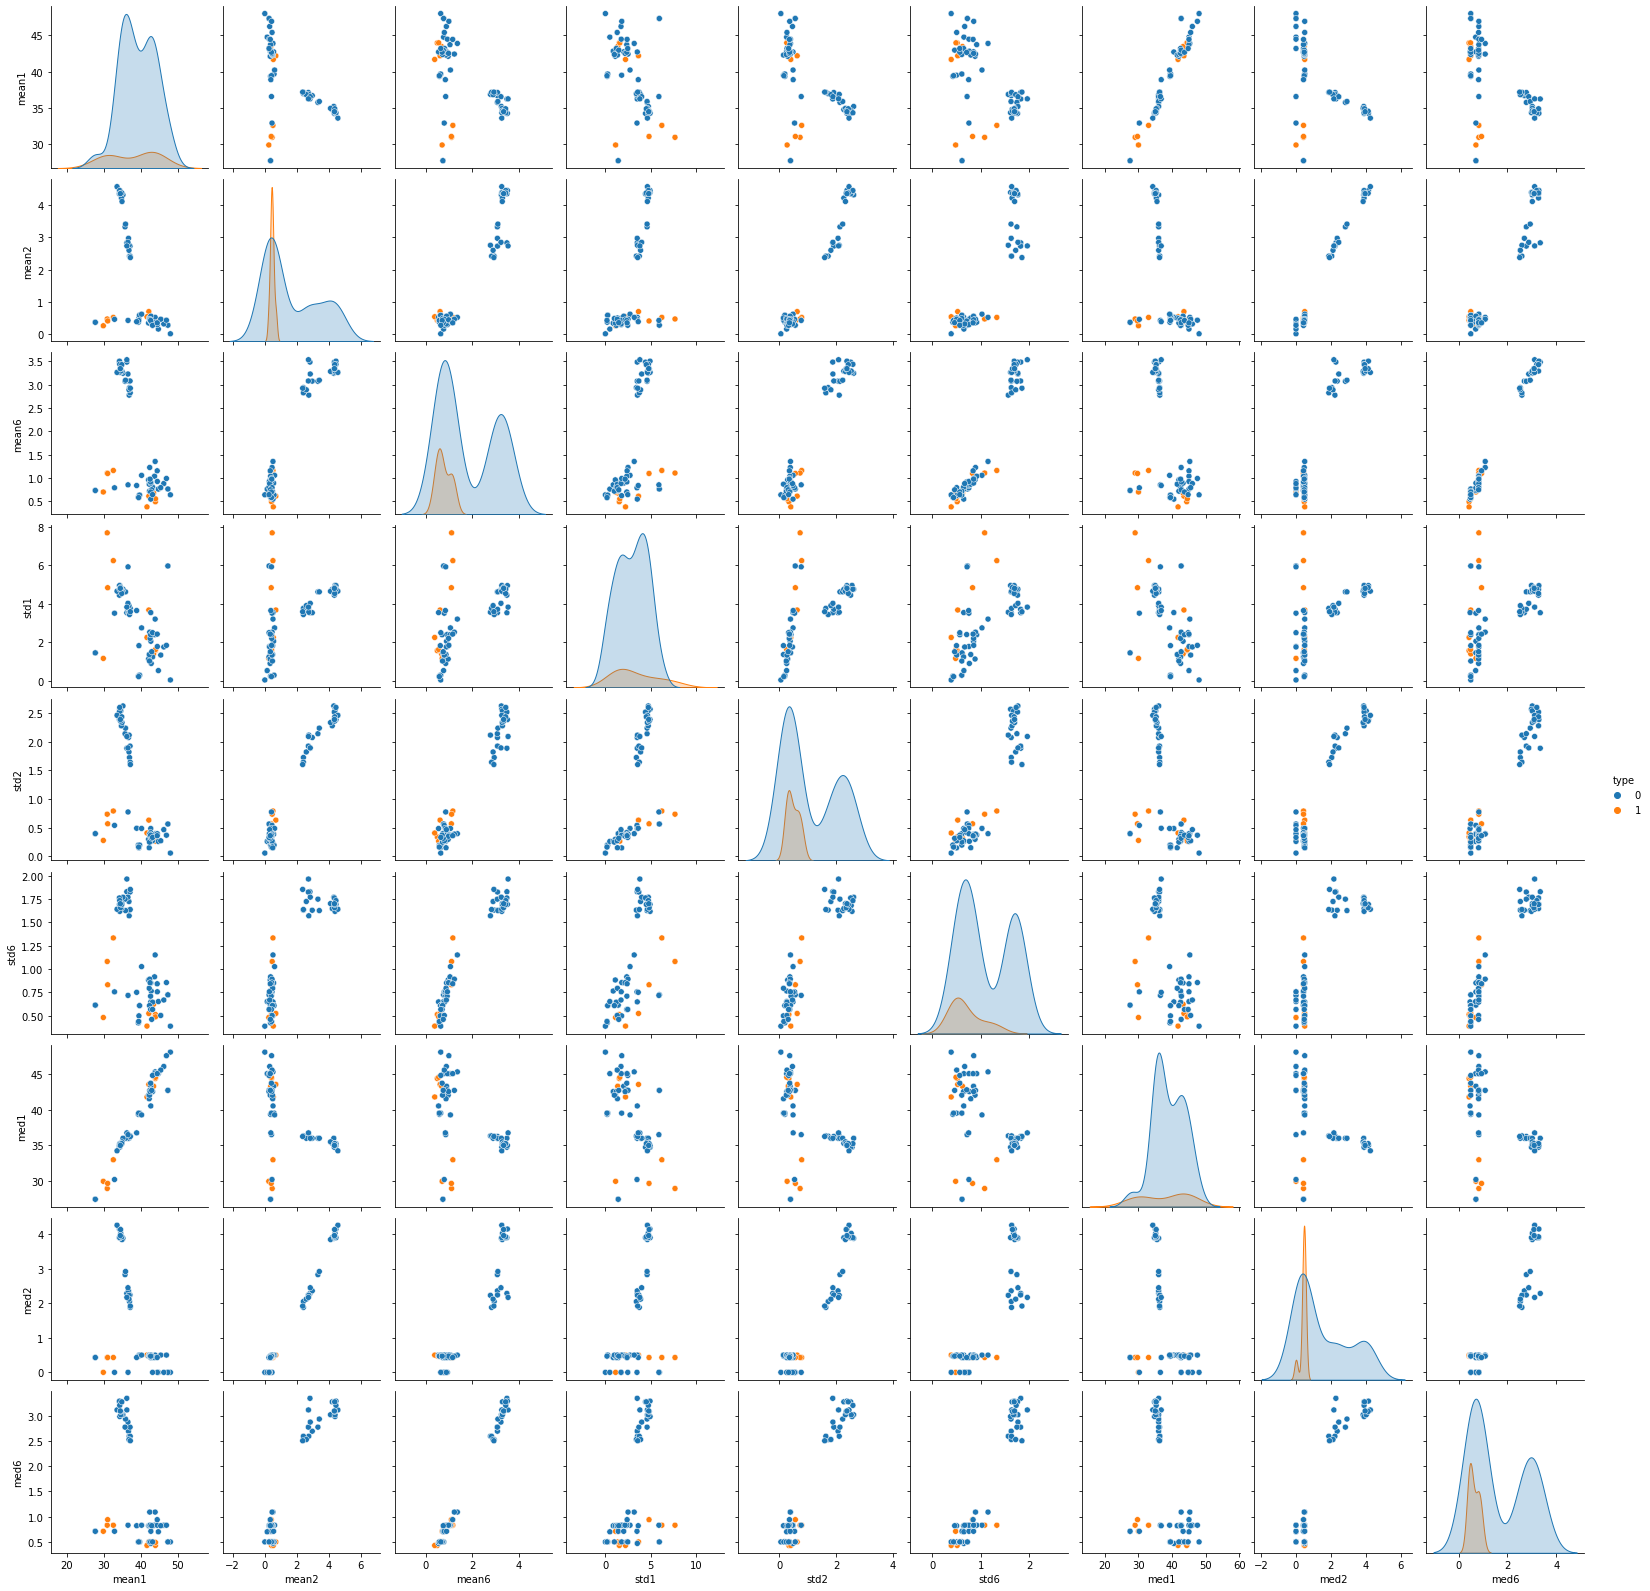

In [10]:
# Plot pairplot for the three time series for each of the training instances. 
sns.pairplot(mms_df, hue='type')
plt.show()

<b>2aii) Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?</b>

In [11]:
# Each training instance has 480 rows, breaking it evenly into two equal length time series will be 240
half_train = []

for i in range(len(train)):
    half_train.append(break_time_series(train[i], 2))

# Check if shape and columns look good.
print(half_train[0].shape)
half_train[0].head(10)

(240, 14)


time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23  \
0     0      42.00       0.71      21.25       0.43      30.00       0.00   
1   250      41.50       0.50      20.25       1.48      31.25       1.09   
2   500      41.50       0.50      14.25       1.92      33.00       0.00   
3   750      40.75       0.83      15.75       0.43      33.00       0.00   
4  1000      40.00       0.71      20.00       2.74      32.75       0.43   
5  1250      41.25       0.83      24.25       0.43      31.50       0.87   
6  1500      42.25       0.43      23.75       0.43      35.25       1.30   
7  1750      43.50       0.87      21.00       0.00      36.00       0.00   
8  2000      42.75       0.83      21.25       0.43      36.00       0.00   
9  2250      43.25       0.43      23.75       0.43      36.00       0.00   

      type  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23  
0  bending      43.33       0.94      18.00       0.00      35.67       0.47  
1  bending      44.20       0.75      19.75       0.83      35.40       1.20  
2  bending      45.00       0.00      21.75       0.83      35.00       1.41  
3  bending      45.00       0.00      23.33       0.47      36.00       0.00  
4  bending      45.00       0.00      24.00       0.00      36.00       0.00  
5  bending      45.50       0.50      24.00       0.00      36.25       0.43  
6  bending      46.25       0.43      24.00       0.00      36.25       0.43  
7  bending      45.50       0.50      24.00       0.00      36.00       0.00  
8  bending      45.00       0.00      21.25       0.43      36.00       0.00  
9  bending      44.75       0.43      18.75       1.30      34.50       1.50

In [12]:
# Extract the mean, median, and standard deviation from the time series.
half_mms_df = extract_features_dataframe(half_train, 2, [1, 2, 6])
print(half_mms_df.shape)
half_mms_df.head()

(69, 19)


type      mean1     mean2     mean6      mean7     mean8    mean12  \
instance                                                                       
1            1  44.057167  0.381042  0.598250  43.851833  0.471458  0.388333   
2            1  43.278875  0.673292  0.640958  41.080750  0.718792  0.586083   
3            1  41.621208  0.623083  0.419083  41.734917  0.448875  0.347500   
4            1  44.117042  0.250042  0.815417  42.792875  0.506125  0.543875   
5            1  43.486208  0.378667  0.524875  44.452042  0.447583  0.585750   

              std1      std2      std6      std7      std8     std12   med1  \
instance                                                                      
1         1.556971  0.329540  0.526656  1.557168  0.342346  0.478528  44.50   
2         3.473355  0.634285  0.554542  3.537481  0.627915  0.491873  45.00   
3         3.118644  0.489595  0.411200  0.595920  0.273050  0.363144  42.33   
4         1.359836  0.314099  0.718016  1.058792  0.260761  0.473445  45.00   
5         1.281976  0.284434  0.486847  1.771251  0.235493  0.487918  43.71   

           med2   med6   med7  med8  med12  
instance                                    
1         0.470  0.500  43.50   0.5   0.00  
2         0.485  0.765  42.00   0.5   0.47  
3         0.500  0.430  41.50   0.5   0.43  
4         0.000  0.710  42.67   0.5   0.50  
5         0.470  0.470  44.50   0.5   0.50

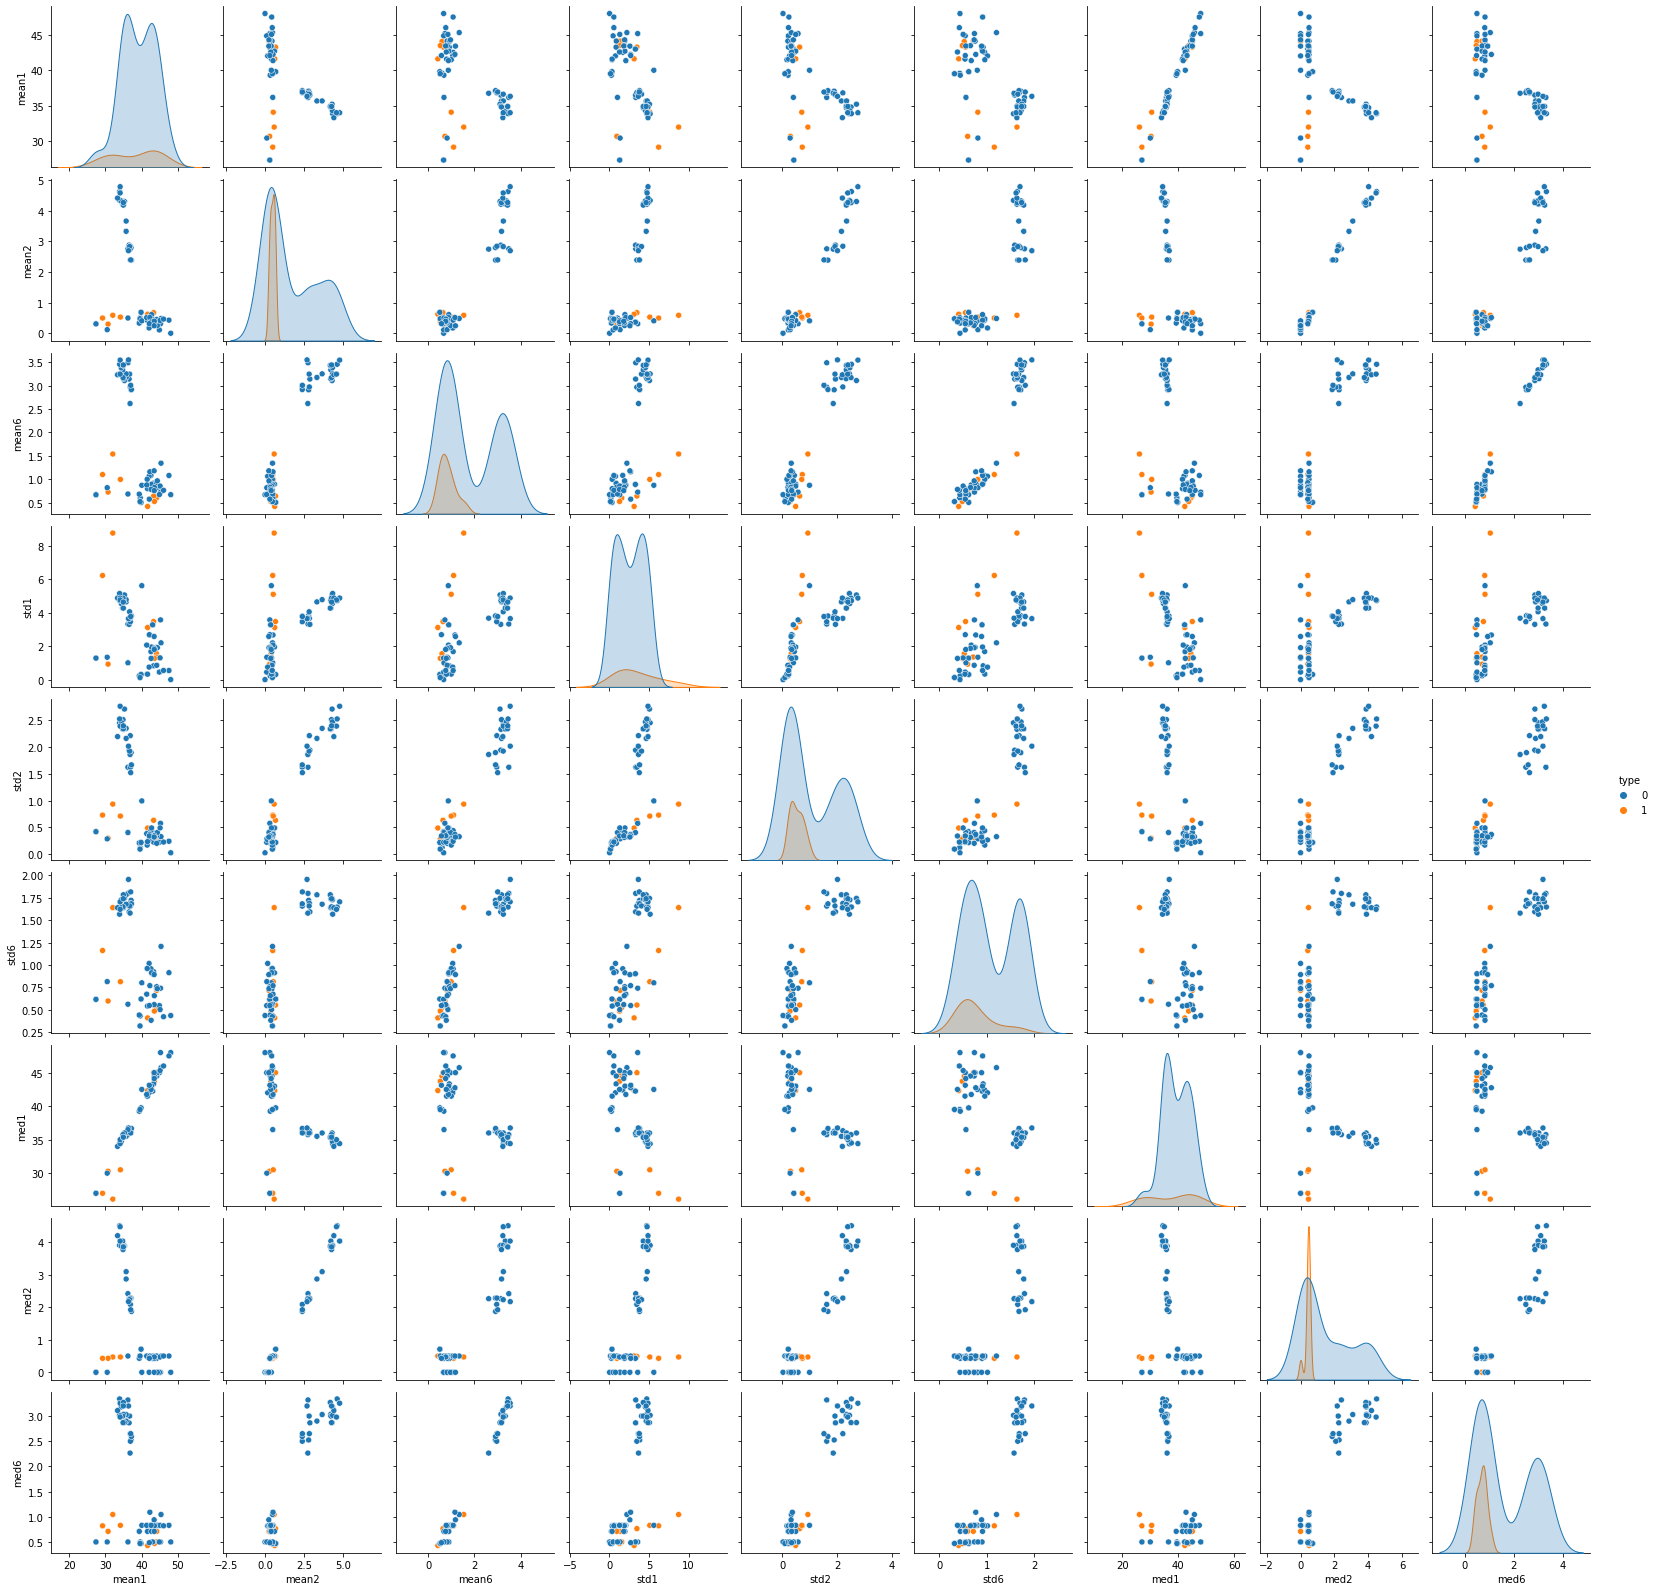

In [13]:
# Plot pairplots for the 3 time series (1, 2, 6) for each of the training instances for comparison with 2ai).
comp_mms = half_mms_df[['mean1', 'mean2', 'mean6', 'std1', 'std2', 'std6', 'med1', 'med2', 'med6', 'type']]
sns.pairplot(comp_mms, hue='type')
plt.show()

In [14]:
print("Difference between pairplots in 2ai) and 2aii) is that the dots for bending is not as clustered in ii) as in i). Since the each time series in the training set was broken into two equal length time series, this result was expected. Since I am looking at mean, median, and standard deviation, reducing the sample size will result in changes in the pairplot.")

Difference between pairplots in 2ai) and 2aii) is that the dots for bending is not as clustered in ii) as in i). Since the each time series in the training set was broken into two equal length time series, this result was expected. Since I am looking at mean, median, and standard deviation, reducing the sample size will result in changes in the pairplot.


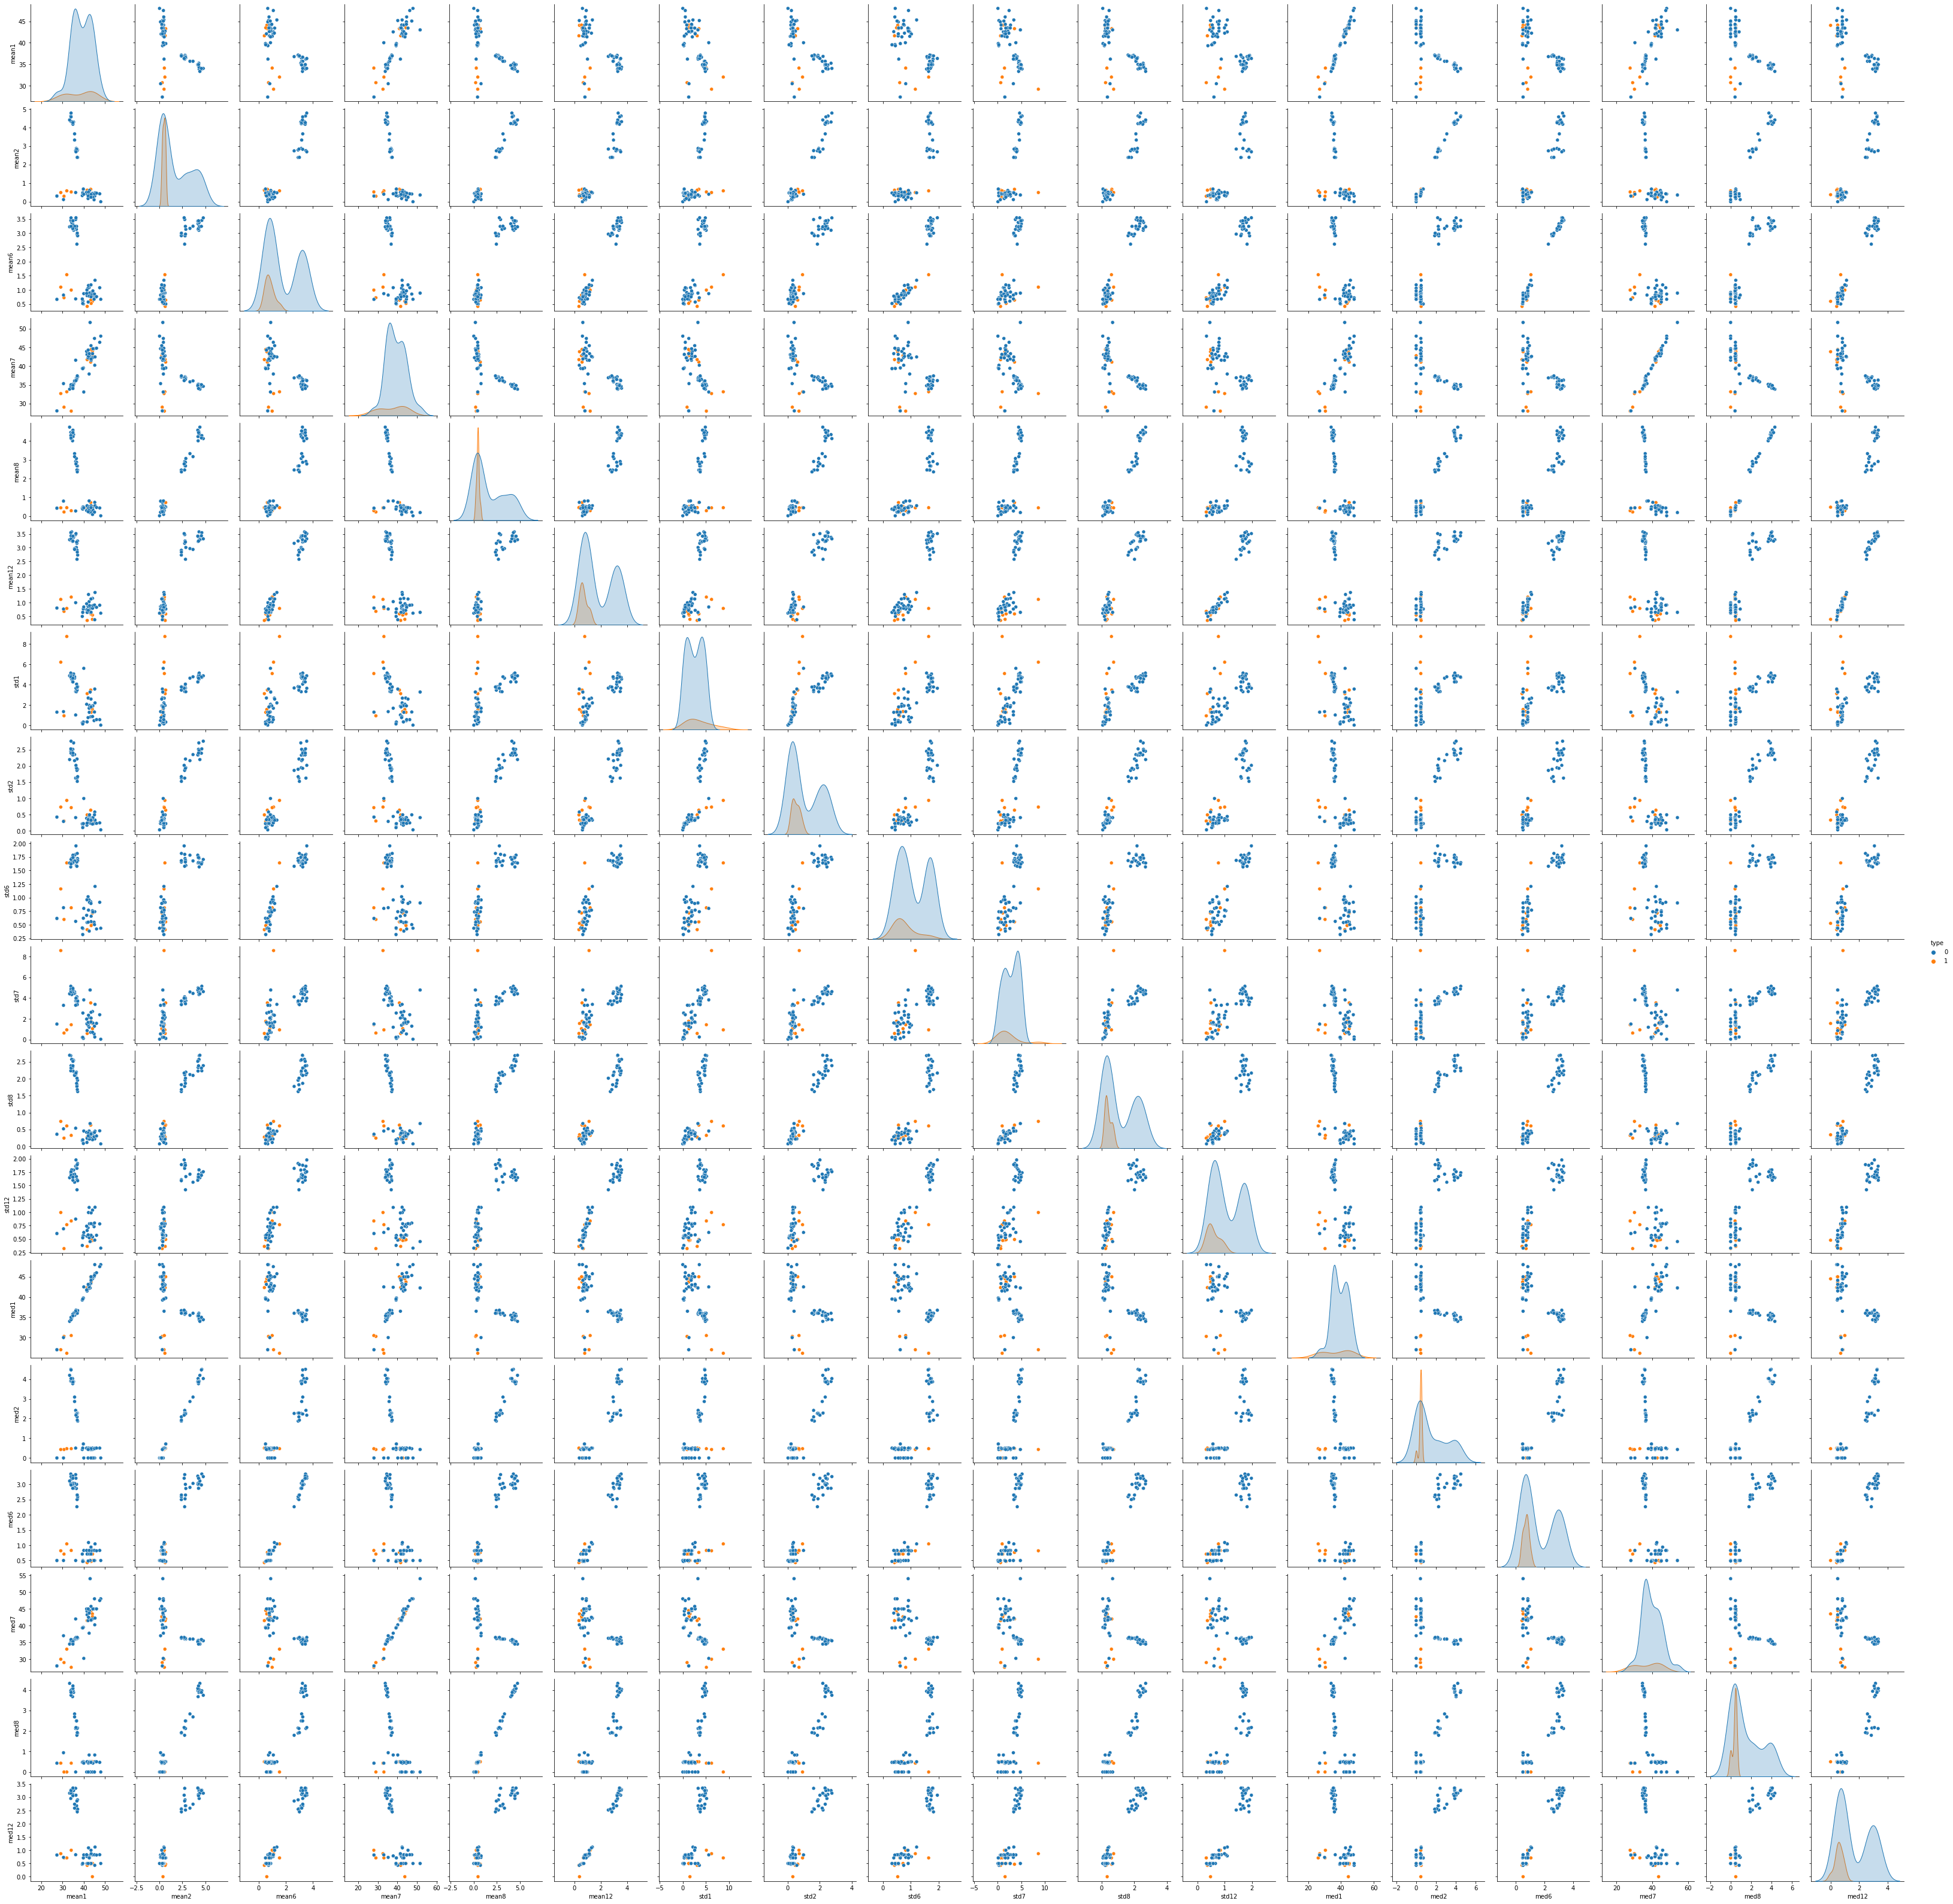

In [15]:
# Plot pairplots for the all six time series (1, 2, 6, 7, 8, 12) for each of the training instances. 
sns.pairplot(half_mms_df, hue='type')
plt.show()

<b>2aiii) Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.</b>

In [16]:
# Prepare data for logistic regression and cross-validation.

# # Key of final_train_series will be number of splits and the value will be a list of 69 time series. Uncomment this block for check.
# final_train_series = {}

# Key of final_train_df will be number of splits and value will be dataframe of mean, median, and standard deviation of each instance.
final_train_df = {}

for l in range(1, 21):
    broken_time = []
    # Propagate the 69 instances of evenly split time series training data in a dictionary.
    for i in range(len(train)):
        broken_time.append(break_time_series(train[i], l))

    # # Save all broken time series in a dictionary. Uncomment this block for check.
    # final_train_series[l] = broken_time

    # Extract the mean, median, and standard deviation from the each time series.
    final_train_df[l] = extract_features_dataframe(broken_time, l, [1, 2, 3, 4, 5, 6])

# # Check the number of instances and the shape of time series. Uncomment this block for check.
# print(len(final_train_series))
# print(len(final_train_series[1]), len(final_train_series[5]), len(final_train_series[10]), len(final_train_series[15]), len(final_train_series[20]))
# print(final_train_series[1][0].shape, final_train_series[5][0].shape, final_train_series[10][0].shape, final_train_series[15][0].shape, final_train_series[20][0].shape)

# Check the extracted time-domain features.
print(len(final_train_df))
print(final_train_df[1].shape, final_train_df[5].shape, final_train_df[10].shape, final_train_df[15].shape, final_train_df[20].shape)


20
(69, 19) (69, 91) (69, 181) (69, 271) (69, 361)


In [17]:
print("There are two steps: Find the best predictors, then apply logistic regression classifer with the selected predictors.\nThe wrong way of cross-validation would be to only apply it to step 2 and not step 1, meaning only applying cross-validation on the logistic regression and not on the predictor selection process.\nThe right way would be to apply cross-validation on both step 1 and step 2. In essence, choosing the CV folds, then for k-1 folds select the set of predictors and fit logsitic regression.")

There are two steps: Find the best predictors, then apply logistic regression classifer with the selected predictors.
The wrong way of cross-validation would be to only apply it to step 2 and not step 1, meaning only applying cross-validation on the logistic regression and not on the predictor selection process.
The right way would be to apply cross-validation on both step 1 and step 2. In essence, choosing the CV folds, then for k-1 folds select the set of predictors and fit logsitic regression.


In [18]:
# Logistic regression model.
lr = LogisticRegression(penalty='none', solver='lbfgs')
l_opt_lr = stratified_rfecv(lr, final_train_df)

{1: 0.956043956043956, 2: 0.9571428571428571, 3: 0.9428571428571428, 4: 0.956043956043956, 5: 0.9571428571428571, 6: 0.9714285714285715, 7: 0.9571428571428573, 8: 0.9703296703296704, 9: 0.9714285714285715, 10: 0.9857142857142858, 11: 0.9857142857142858, 12: 0.9857142857142858, 13: 0.9857142857142858, 14: 0.9703296703296704, 15: 0.9857142857142858, 16: 0.9857142857142858, 17: 0.9857142857142858, 18: 0.9857142857142858, 19: 0.9857142857142858, 20: 0.9857142857142858}
All of the following splits has the good mean_test_score: [10, 11, 12, 13, 15, 16, 17, 18, 19, 20].
Choosing the smallest l from the list, splitting data into 10 has maximum mean_test_score at 0.9857142857142858.


In [19]:
# Extract the selected features and make a new dataframe from the extracted features.
selected_feats = opt_stratified_rfecv(lr, final_train_df, l_opt_lr)
final_train_optl_df = final_train_df[l_opt_lr][selected_feats]
final_train_optl_df = pd.concat([final_train_optl_df, final_train_df[l_opt_lr]['type']], axis=1)

print(final_train_optl_df.shape)
final_train_optl_df.head()

Optimal number of features is: 75 and the features selected are the following: [  4   5  10  11  13  16  17  18  19  20  22  23  27  29  30  31  33  34
  35  36  37  38  39  41  42  43  45  47  50  52  53  54  57  58  59  68
  78  90  94  96  98 108 112 124 125 128 130 131 132 136 137 138 140 142
 143 147 149 150 151 154 156 157 158 159 161 162 163 165 167 170 172 174
 177 178 179].
In other words, best (l,p) pair is (10, 75).
Selected features: ['mean5', 'mean6', 'mean11', 'mean12', 'mean14', 'mean17', 'mean18', 'mean19', 'mean20', 'mean21', 'mean23', 'mean24', 'mean28', 'mean30', 'mean31', 'mean32', 'mean34', 'mean35', 'mean36', 'mean37', 'mean38', 'mean39', 'mean40', 'mean42', 'mean43', 'mean44', 'mean46', 'mean48', 'mean51', 'mean53', 'mean54', 'mean55', 'mean58', 'mean59', 'mean60', 'std9', 'std19', 'std31', 'std35', 'std37', 'std39', 'std49', 'std53', 'med5', 'med6', 'med9', 'med11', 'med12', 'med13', 'med17', 'med18', 'med19', 'med21', 'med23', 'med24', 'med28', 'med30', 'med31'

mean5     mean6     mean11    mean12    mean14     mean17  \
instance                                                                  
1         35.590208  0.378750  36.375208  0.508333  0.357708  36.520625   
2         36.474792  0.636667  37.222292  0.839375  0.617917  36.024375   
3         30.482500  0.477083  28.327917  0.379375  0.795417  28.185833   
4         25.788125  0.708125  23.529583  0.692917  0.222708  23.696250   
5         20.613333  0.713542  28.053750  0.350208  0.445417  21.663333   

            mean18     mean19    mean20     mean21  ...  med44  med46  med48  \
instance                                            ...                        
1         0.615625  44.360833  0.376875  23.003333  ...  0.470   0.47  0.905   
2         0.487500  42.395625  0.900625  22.979167  ...  0.765   1.12  0.500   
3         0.438125  42.672708  0.623333  19.757917  ...  0.470   0.43  0.430   
4         1.042500  43.713542  0.473333  17.402083  ...  0.470   0.43  0.430   
5         0.587083  44.338542  0.378125  17.510417  ...  0.470   0.43  0.500   

           med51   med53   med55  med58  med59  med60  type  
instance                                                     
1         19.000  36.000  43.500  0.430  36.00  0.000     1  
2         23.125  26.875  41.125  0.825  30.00  0.430     1  
3         18.500  29.670  41.500  0.500  26.75  0.430     1  
4         12.585  23.500  43.000  0.500  22.25  0.485     1  
5         14.875  21.500  44.500  0.450  22.75  0.500     1  

[5 rows x 76 columns]

In [20]:
# Fit the Logistic Regression on selected features
X_train_selected = final_train_optl_df.drop(['type'], axis=1)
y_train_selected = final_train_optl_df['type']
lr.fit(X_train_selected, y_train_selected)

# Cross validation on model after training.
train_score = cross_val_score(lr, X_train_selected, y_train_selected, cv=StratifiedKFold(5))
print(f"Cross validation accuracy score on training data is {train_score.mean()} with {train_score.std()}")

Cross validation accuracy score on training data is 1.0 with 0.0


<b>2aiv) Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.</b>

1.0
True negative: 60, False positive: 0, False negative: 0, True positive: 9


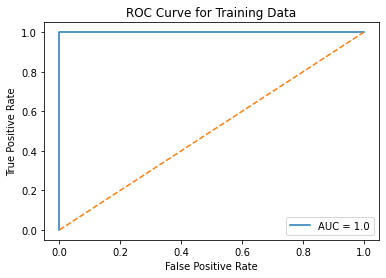

In [21]:
# Predict y_train from X_train.
y_train_pred = lr.predict(X_train_selected)
print(accuracy_score(y_train_selected, y_train_pred))

# Confusion matrix on train data.
tn, fp, fn, tp = confusion_matrix(y_train_selected, y_train_pred).ravel()
print(f"True negative: {tn}, False positive: {fp}, False negative: {fn}, True positive: {tp}")

# Show thr ROC and AUC for the classifier on train data.
plot_ROC(X_train_selected, y_train_selected, "Training Data", lr)

In [22]:
# Calculate the parameters and p-values using statsmodel
lr_sm = sm.Logit(y_train_selected, X_train_selected).fit()
lr_sm.summary()

         Current function value: 0.000066
         Iterations: 35


/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   type   No. Observations:                   69
Model:                          Logit   Df Residuals:                        3
Method:                           MLE   Df Model:                           65
Date:                Mon, 17 Oct 2022   Pseudo R-squ.:                  0.9998
Time:                        22:36:26   Log-Likelihood:             -0.0045204
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                    0.8469
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mean5         -7.2187   1.44e+07  -5.02e-07      1.000   -2.82e+07    2.82e+07
mean6        -16.0532        nan        nan        nan         nan         nan
mean11         2.7653   1.15e+07    2.4e-07      1.000   -2.26e+07    2.26e+07
mean12         2.8431   3.25e+08   8.74e-09      1.000   -6.38e+08    6.38e+08
mean14        -3.2631        nan        nan        nan         nan         nan
mean17         8.9272        nan        nan        nan         nan         nan
mean18         5.5732   5.41e+08   1.03e-08      1.000   -1.06e+09    1.06e+09
mean19         1.9914        nan        nan        nan         nan         nan
mean20         4.0123   4.08e+08   9.83e-09      1.000      -8e+08       8e+08
mean21         0.9813    1.2e+07   8.17e-08      1.000   -2.36e+07    2.36e+07
mean23         2.1089   9.24e+06   2.28e-07      1.000   -1.81e+07    1.81e+07
mean24         6.6184        nan        nan        nan         nan         nan
mean28         0.4155        nan        nan        nan         nan         nan
mean30         7.7040   1.37e+08   5.61e-08      1.000   -2.69e+08    2.69e+08
mean31         4.9616        nan        nan        nan         nan         nan
mean32        -5.5727   6.97e+08     -8e-09      1.000   -1.37e+09    1.37e+09
mean34         2.4270   1.06e+08    2.3e-08      1.000   -2.07e+08    2.07e+08
mean35         8.6736        nan        nan        nan         nan         nan
mean36        -5.5584   2.97e+08  -1.87e-08      1.000   -5.83e+08    5.83e+08
mean37        -3.7901        nan        nan        nan         nan         nan
mean38        11.6129   4.35e+08   2.67e-08      1.000   -8.53e+08    8.53e+08
mean39        -0.9711        nan        nan        nan         nan         nan
mean40         0.2183        nan        nan        nan         nan         nan
mean42        -6.5871        nan        nan        nan         nan         nan
mean43        11.8905        nan        nan        nan         nan         nan
mean44        -8.8649   7.88e+08  -1.12e-08      1.000   -1.54e+09    1.54e+09
mean46         6.4722   4.88e+08   1.33e-08      1.000   -9.57e+08    9.57e+08
mean48        -4.6990        nan        nan        nan         nan         nan
mean51        -9.6694   5.71e+07  -1.69e-07      1.000   -1.12e+08    1.12e+08
mean53         7.7348        nan        nan        nan         nan         nan
mean54       -23.4219   2.78e+08  -8.43e-08      1.000   -5.45e+08    5.45e+08
mean55        -2.3504        nan        nan        nan         nan         nan
mean58        -6.3462        nan        nan        nan         nan         nan
mean59        -0.7817   1.94e+07  -4.03e-08      1.000    -3.8e+07     3.8e+07
mean60         0.3262        nan        nan        nan         nan         nan
std9           0.7650   8.74e+07   8.76e-09      1.000   -1.71e+08    1.71e+08
std19         -6.3548   1.76e+08  -3.62e-08      1.000   -3.44e+08    3.44e+08
std31         -0.0749        nan        nan        nan         nan         nan
st

<b>2av) Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.</b>

In [23]:
# Break the test data into 10 even parts (as l=10,p=75 was the optimal determined by 2aiii).
test_split_optlr = []

for i in range(len(test)):
    test_split_optlr.append(break_time_series(test[i], l_opt_lr))

final_test_df = extract_features_dataframe(test_split_optlr, l_opt_lr, [1, 2, 3, 4, 5, 6], train=False)

print(final_test_df.shape)
final_test_df.head()

(19, 181)


type      mean1     mean2      mean3     mean4      mean5     mean6  \
instance                                                                        
1            1  40.401250  0.551458  20.040000  0.466250  33.332292  0.458333   
2            1  43.425417  0.551458  19.505208  1.329375  32.378542  0.264583   
3            1  20.637083  1.084792  21.950625  0.571458  25.909583  0.626042   
4            1  27.796667  0.094375  18.733542  1.101667  16.345208  1.156250   
5            0  36.751667  2.403542  17.046042  3.488958  19.735208  3.119792   

              mean7     mean8      mean9  ...   med51  med52   med53  med54  \
instance                                  ...                                 
1         41.805625  0.241042  14.611042  ...  21.250  0.500  30.000  0.430   
2         43.246250  0.547917  20.058750  ...  21.000  0.765  32.290  0.430   
3         23.524167  0.558750  17.380417  ...  20.585  0.770  19.710  1.000   
4         29.729167  0.160000  20.652708  ...  23.875  1.400  14.415  1.455   
5         36.908333  2.144375  16.689167  ...  16.460  1.890  20.750  2.270   

           med55  med56   med57  med58   med59  med60  
instance                                               
1         42.750   0.50  24.500  0.500  31.000  0.430  
2         44.625   0.47  15.625  1.455  32.000  0.430  
3         27.000   0.00  22.750  0.430  21.000  0.500  
4         22.375   0.47  18.750  0.710  25.750  1.455  
5         37.000   1.84  16.040  2.465  20.375  2.355  

[5 rows x 181 columns]

In [24]:
# Use only the selected features determined in 2aiii where p=10.
X_test = final_test_df.loc[:, selected_feats]
y_test = final_test_df['type']

# Fit test data to the model.
y_hat = lr.predict(X_test)
# Find accuracy score
test_accu = accuracy_score(y_test, y_hat)
print(f"Accuracy on the test set is {test_accu}.")


Accuracy on the test set is 1.0.


In [25]:
# Compare training score vs testing score.
print(f"Since we have well-separated classes, train score from cross-validation ({train_score.mean()}) is the same as test accuracy score ({test_accu}).")

Since we have well-separated classes, train score from cross-validation (1.0) is the same as test accuracy score (1.0).


<b>2avi) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?</b>

True negative: 15, False positive: 0, False negative: 0, True positive: 4


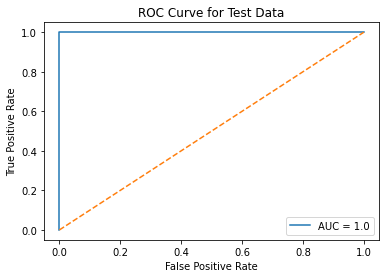

In [26]:
# Calculate the confusion matrix of test data.
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print(f"True negative: {tn}, False positive: {fp}, False negative: {fn}, True positive: {tp}")

# Show ROC and AUC for test data.
plot_ROC(X_test, y_test, "Test Data", lr)

In [27]:
print(f"There are {fp} false positive and {fn} false negative in the prediction for the test data, the test accuracy score is {test_accu}, and the AUC is 1.0, so yes, the classes are very well-separated.")

There are 0 false positive and 0 false negative in the prediction for the test data, the test accuracy score is 1.0, and the AUC is 1.0, so yes, the classes are very well-separated.


<b>2avii) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.</b>

In [28]:
# Transform training dataset
resample_train = {}

for l in range(1, 21):
    X_train = final_train_df[l].drop(['type'], axis=1)
    y_train = final_train_df[l]['type']
    X_train_cc, y_train_cc = SMOTE().fit_resample(X_train, y_train)

    resample_train[l] = pd.concat([X_train_cc, y_train_cc], axis=1)

print(len(resample_train))
print(final_train_df[2].shape, resample_train[2].shape)

20
(69, 37) (120, 37)


In [29]:
# Logistic regression model.
lr_cc = LogisticRegression(penalty='none', solver='lbfgs', max_iter=300)
l_opt_cc = stratified_rfecv(lr_cc, resample_train)

{1: 0.9666666666666668, 2: 0.975, 3: 0.9833333333333334, 4: 0.9833333333333334, 5: 0.9833333333333334, 6: 0.9833333333333334, 7: 0.9833333333333334, 8: 0.9833333333333334, 9: 0.9916666666666668, 10: 0.9916666666666668, 11: 0.9916666666666668, 12: 0.9833333333333334, 13: 0.9916666666666668, 14: 0.9833333333333334, 15: 0.9916666666666668, 16: 0.9916666666666668, 17: 0.9833333333333334, 18: 0.9916666666666668, 19: 0.9916666666666668, 20: 1.0}
All of the following splits has the good mean_test_score: [20].
Choosing the smallest l from the list, splitting data into 20 has maximum mean_test_score at 1.0.


In [30]:
print(l_opt_cc)

20


In [31]:
# Extract the selected features and make a new dataframe from the extracted features.
selected_feats_cc = opt_stratified_rfecv(lr_cc, resample_train, l_opt_cc)
resample_train_opt_df = resample_train[l_opt_cc][selected_feats_cc]
resample_train_opt_df = pd.concat([resample_train_opt_df, resample_train[l_opt_cc]['type']], axis=1)

print(resample_train_opt_df.shape)
resample_train_opt_df.head()

Optimal number of features is: 14 and the features selected are the following: [ 16  22  34  66  90 104 112 126 132 156 180 256 262 344].
In other words, best (l,p) pair is (20, 14).
Selected features: ['mean17', 'mean23', 'mean35', 'mean67', 'mean91', 'mean105', 'mean113', 'std7', 'std13', 'std37', 'std61', 'med17', 'med23', 'med105']
(120, 15)


mean17     mean23     mean35     mean67     mean91    mean105  \
0  36.382083  36.368333  37.020417  44.618333  44.947083  18.662917   
1  37.715417  36.729167  36.322917  41.600417  41.194583  20.364167   
2  28.854167  27.801667  28.397917  41.742500  41.656667  17.187500   
3  23.205000  23.854167  23.510417  42.405833  42.201250  11.819167   
4  29.968750  26.138750  22.698333  44.061667  41.937083  14.600833   

     mean113      std7     std13     std37     std61   med17   med23  med105  \
0  36.055417  0.401670  0.248954  1.673907  0.780312  36.500  36.500   18.29   
1  28.610833  3.362642  2.346582  4.106999  3.574059  37.875  37.000   22.75   
2  26.687500  2.134730  1.934207  3.874567  0.397762  29.875  28.125   18.10   
3  23.561250  0.141165  0.084458  0.819602  0.580145  23.710  24.000   12.25   
4  22.452083  1.214692  0.347975  0.721369  1.946261  30.000  30.000   14.75   

   type  
0     1  
1     1  
2     1  
3     1  
4     1

In [32]:
# Fit the Logistic Regression on selected features
X_train_resample = resample_train_opt_df.drop(['type'], axis=1)
y_train_resample = resample_train_opt_df['type']

lr_cc.fit(X_train_resample, y_train_resample)

# Cross validation on model after training.
train_score_resample = cross_val_score(lr_cc, X_train_resample, y_train_resample, cv=StratifiedKFold(5))
print(f"Cross validation accuracy score on training data is {train_score_resample.mean()} with {train_score_resample.std()}")

Cross validation accuracy score on training data is 1.0 with 0.0


1.0
True negative: 60, False positive: 0, False negative: 0, True positive: 60


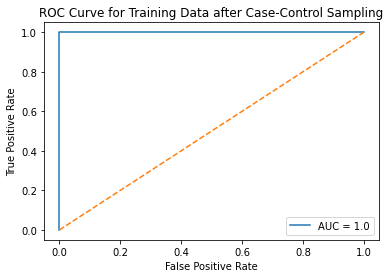

In [33]:
# Predict y_train from X_train.
y_train_pred_cc = lr_cc.predict(X_train_resample)
print(accuracy_score(y_train_resample, y_train_pred_cc))

# Confusion matrix on train data.
tn, fp, fn, tp = confusion_matrix(y_train_resample, y_train_pred_cc).ravel()
print(f"True negative: {tn}, False positive: {fp}, False negative: {fn}, True positive: {tp}")

# Show thr ROC and AUC for the classifier on train data.
plot_ROC(X_train_resample, y_train_resample, "Training Data after Case-Control Sampling", lr_cc)

In [34]:
# Break the test data into 16 even parts (as l=16,p=16 was the optimal determined by 2aiii).
test_split_opt_cc = []

for i in range(len(test)):
    test_split_opt_cc.append(break_time_series(test[i], l_opt_cc))    

final_test_df_cc = extract_features_dataframe(test_split_opt_cc, l_opt_cc, [1, 2, 3, 4, 5, 6], train=False)

print(final_test_df_cc.shape)
final_test_df_cc.head()

(19, 361)


type      mean1     mean2      mean3     mean4      mean5     mean6  \
instance                                                                        
1            1  39.673750  0.474583  21.746667  0.333333  33.000000  0.092917   
2            1  43.437917  0.524583  17.590417  1.984167  31.850833  0.335000   
3            1  19.420000  1.450000  23.405000  0.416250  25.332917  0.825000   
4            1  26.989583  0.038750  20.848333  0.709583  16.645417  1.255833   
5            0  36.107500  2.463333  16.395833  4.017917  19.951250  3.237917   

              mean7     mean8      mean9  ...  med111  med112  med113  med114  \
instance                                  ...                                   
1         41.128750  0.628333  18.333333  ...  24.250   0.710  32.625   0.450   
2         43.412917  0.578333  21.420000  ...  16.875   1.470  31.750   0.430   
3         21.854167  0.719583  20.496250  ...  23.330   0.430  21.250   0.500   
4         28.603750  0.150000  16.618750  ...  20.375   0.710  25.500   1.275   
5         37.395833  2.343750  17.696250  ...  15.585   2.485  20.000   2.200   

          med115  med116  med117  med118  med119  med120  
instance                                                  
1         43.250   0.500  24.750   0.470  30.000   0.000  
2         44.000   0.500  15.375   1.455  32.125   0.430  
3         27.000   0.000  21.415   0.430  20.750   0.495  
4         21.875   0.430  17.670   0.770  25.750   1.710  
5         37.250   1.855  16.710   2.450  20.875   2.470  

[5 rows x 361 columns]

Accuracy on the test set is 1.0, lower than test accuracy before resampling 1.0.
True negative: 15, False positive: 0, False negative: 0, True positive: 4


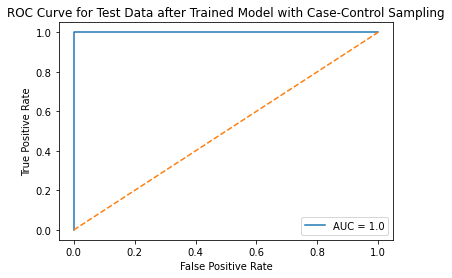

In [35]:
# Use only the selected features determined in 2aiii where p=10.
X_test_cc = final_test_df_cc.loc[:, selected_feats_cc]
y_test_cc = final_test_df_cc['type']

# Fit test data to the model.
y_hat_cc = lr_cc.predict(X_test_cc)
# Find accuracy score
test_accu_cc = accuracy_score(y_test_cc, y_hat_cc)
print(f"Accuracy on the test set is {test_accu_cc}, lower than test accuracy before resampling {test_accu}.")

# Confusion matrix on test data.
tn, fp, fn, tp = confusion_matrix(y_test_cc, y_hat_cc).ravel()
print(f"True negative: {tn}, False positive: {fp}, False negative: {fn}, True positive: {tp}")

# Show thr ROC and AUC for the classifier on train data.
plot_ROC(X_test_cc, y_test_cc, "Test Data after Trained Model with Case-Control Sampling", lr_cc)

<b>2b) Binary Classification Using L1-penalized logistic regression:<br>
2bi) Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using p- values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.</b>

In [36]:
# Normalize X of training dataset
nrml_train = {}

for l in range(1, 21):
    scaler = MinMaxScaler()

    X_train = final_train_df[l].drop(['type'], axis=1)
    X_train_nrml = scaler.fit_transform(X_train)
    X_train_nrml = pd.DataFrame(X_train_nrml, columns=X_train.columns, index=[x for x in range(1, 70)])

    y_train = final_train_df[l]['type']

    # Recreate a dataframe with all train data, but X is now normalized.
    nrml_train[l] = pd.concat([X_train_nrml, y_train], axis=1)

print(len(nrml_train))
print(nrml_train[1].shape, nrml_train[5].shape, nrml_train[10].shape, nrml_train[15].shape, nrml_train[20].shape)

20
(69, 19) (69, 91) (69, 181) (69, 271) (69, 361)


In [37]:
lr_cv = LogisticRegressionCV(cv=5, penalty='l1', scoring='roc_auc', solver='liblinear')
# Select featrues using backward feature selection and use 5-fold stratified cross validation to find best number of splits for time series.
l1_dict_nrml = {}

for l in range(1, 21):
    X_train_nrml = nrml_train[l].drop(['type'], axis=1)
    y_train_nrml = nrml_train[l]['type']
    lr_cv.fit(X_train_nrml, y_train_nrml)
    lr_l1 = LogisticRegression(penalty='l1', C=lr_cv.C_[0], solver='liblinear')
    selector = RFECV(lr_l1, step=1, cv=StratifiedKFold(5), scoring='accuracy')
    selector = selector.fit(X=X_train_nrml, y=y_train_nrml)
    l1_dict_nrml[l] = max(selector.cv_results_['mean_test_score'])

print(l1_dict_nrml)

# Find the best number of splits for time series.
max_val = max(l1_dict_nrml.values())
max_key = []
for key, val in l1_dict_nrml.items():
    if val == max_val:
        max_key.append(key)

print(f"All of the following splits has the good mean_test_score: {max_key}.")
print(f"Choosing the smallest l from the list, splitting data into {max(l1_dict_nrml, key=l1_dict_nrml.get)} has maximum mean_test_score at {max_val}.")
l_opt_nrml = max_key[0]


/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/s

{1: 0.9274725274725275, 2: 0.956043956043956, 3: 0.9714285714285715, 4: 0.9714285714285715, 5: 0.9714285714285715, 6: 0.9571428571428573, 7: 0.9285714285714285, 8: 0.9428571428571428, 9: 0.9703296703296704, 10: 0.9571428571428573, 11: 0.9571428571428573, 12: 0.9714285714285715, 13: 0.9428571428571428, 14: 0.9560439560439562, 15: 0.9417582417582417, 16: 0.9571428571428571, 17: 0.9714285714285715, 18: 0.9714285714285715, 19: 0.9571428571428571, 20: 0.9571428571428571}
All of the following splits has the good mean_test_score: [3, 4, 5, 12, 17, 18].
Choosing the smallest l from the list, splitting data into 3 has maximum mean_test_score at 0.9714285714285715.


In [38]:
# Extract the selected features and make a new dataframe from the extracted features.
X_train_nrml_opt = nrml_train[l_opt_nrml].drop(['type'], axis=1)
y_train_nrml_opt = nrml_train[l_opt_nrml]['type']
lr_cv.fit(X_train_nrml_opt, y_train_nrml_opt)
lr_l1_opt = LogisticRegression(penalty='l1', C=lr_cv.C_[0], solver='liblinear')
selector_opt_l1 = RFECV(lr_l1_opt, step=1, cv=StratifiedKFold(5), scoring='accuracy')
selector_opt_l1 = selector_opt_l1.fit(X=X_train_nrml_opt, y=y_train_nrml_opt)

print(f"Optimal number of features is: {selector_opt_l1.n_features_} and the features selected are the following: {selector_opt_l1.get_support(indices=True)}.")
print(f"In other words, best (l,p) pair is ({l_opt_nrml}, {selector_opt_l1.n_features_}).")

# Find the best number of splits for time series.
selected_opt_l1 = []
for i in selector_opt_l1.get_support(indices=True):
    selected_opt_l1.append(X_train_nrml_opt.columns[i])

print(f"Selected features: {selected_opt_l1}")

nrml_train_l1_opt_df = nrml_train[l_opt_nrml][selected_opt_l1]
nrml_train_l1_opt_df = pd.concat([nrml_train_l1_opt_df, nrml_train[l_opt_nrml]['type']], axis=1)

print(nrml_train_l1_opt_df.shape)
nrml_train_l1_opt_df.head()

/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Optimal number of features is: 1 and the features selected are the following: [4].
In other words, best (l,p) pair is (3, 1).
Selected features: ['mean5']
(69, 2)


/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


mean5  type
1  0.994574     1
2  1.000000     1
3  0.777645     1
4  0.628480     1
5  0.610046     1

Cross validation accuracy score on training data is 0.9714285714285715 with 0.05714285714285716
0.9710144927536232
True negative: 60, False positive: 0, False negative: 2, True positive: 7


/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


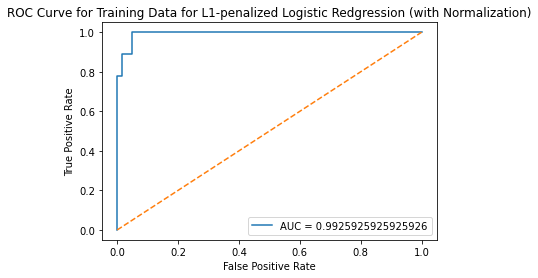

In [39]:
# Fit the Logistic Regression on selected features
X_train_nrml_l1 = nrml_train_l1_opt_df.drop(['type'], axis=1)
y_train_l1 = nrml_train_l1_opt_df['type']

lr_l1_opt.fit(X_train_nrml_l1, y_train_l1)

# Cross validation on model after training.
train_score_nrml_l1 = cross_val_score(lr_l1_opt, X_train_nrml_l1, y_train_l1, cv=5)
print(f"Cross validation accuracy score on training data is {train_score_nrml_l1.mean()} with {train_score_nrml_l1.std()}")

# Predict y_train from X_train.
y_train_pred_l1 = lr_l1_opt.predict(X_train_nrml_l1)
print(accuracy_score(y_train_l1, y_train_pred_l1))

# Confusion matrix on train data.
tn, fp, fn, tp = confusion_matrix(y_train_l1, y_train_pred_l1).ravel()
print(f"True negative: {tn}, False positive: {fp}, False negative: {fn}, True positive: {tp}")

# Show thr ROC and AUC for the classifier on train data.
plot_ROC(X_train_nrml_l1, y_train_l1, "Training Data for L1-penalized Logistic Redgression (with Normalization)", lr_l1_opt)

In [40]:
# Break the test data based on best (l,p) pair.
test_split_opt = []

for i in range(len(test)):
    test_split_opt.append(break_time_series(test[i], l_opt_nrml))    

final_test_df_l1 = extract_features_dataframe(test_split_opt, l_opt_nrml, [1, 2, 3, 4, 5, 6], train=False)

print(final_test_df_l1.shape)
final_test_df_l1.head()

# Normalize X of test dataset
nrml_test = {}

scaler = MinMaxScaler()

X_train = final_train_df[l_opt_nrml].drop(['type'], axis=1)
X_train_nrml = scaler.fit_transform(X_train)
X_test = final_test_df_l1.drop(['type'], axis=1)
X_test_nrml = scaler.transform(X_test)
X_test_nrml = pd.DataFrame(X_test_nrml, columns=X_test.columns, index=[x for x in range(1, 20)])
X_test_nrml = X_test_nrml[selected_opt_l1]

y_test_l1 = final_test_df_l1['type']

print(X_test_nrml.shape)
print(y_test_l1.shape)


(19, 55)
(19, 1)
(19,)


Accuracy on the test set is 0.9473684210526315.
True negative: 15, False positive: 0, False negative: 1, True positive: 3


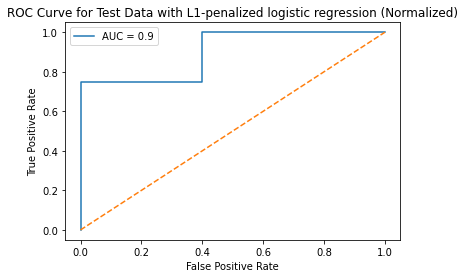

In [41]:
# Fit test data to the model.
y_hat_l1 = lr_l1_opt.predict(X_test_nrml)
# Find accuracy score
test_accu_l1 = accuracy_score(y_test_l1, y_hat_l1)
print(f"Accuracy on the test set is {test_accu_l1}.")

# Confusion matrix on test data.
tn, fp, fn, tp = confusion_matrix(y_test_l1, y_hat_l1).ravel()
print(f"True negative: {tn}, False positive: {fp}, False negative: {fn}, True positive: {tp}")

# Show thr ROC and AUC for the classifier on train data.
plot_ROC(X_test_nrml, y_test_l1, "Test Data with L1-penalized logistic regression (Normalized)", lr_l1_opt)

<b>2bii) Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?</b>

In [42]:
print(f"The test accuracy for backward selection without penalty (with case-control sampling) is {test_accu_cc} and the test accuracy for L1-penalized regression with normalization is {test_accu_l1}. I think backward selection is easier to implement.")

The test accuracy for backward selection without penalty (with case-control sampling) is 1.0 and the test accuracy for L1-penalized regression with normalization is 0.9473684210526315. I think backward selection is easier to implement.


<b>2c) Multi-class Classification:<br>
2ci) Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.</b>

In [43]:
mc_train_df = {}

for l in range(1, 21):
    broken_time = []
    # Propagate the 69 instances of evenly split time series training data in a dictionary.
    for i in range(len(train)):
        broken_time.append(break_time_series(train[i], l))

    # Extract the mean, median, and standard deviation from the each time series.
    mc_train_df[l] = multiclass_extract_features_dataframe(broken_time, l, [1, 2, 3, 4, 5, 6])

# Check the extracted time-domain features.
print(len(mc_train_df))
print(mc_train_df[1].shape, mc_train_df[5].shape, mc_train_df[10].shape, mc_train_df[15].shape, mc_train_df[20].shape)

20
(69, 19) (69, 91) (69, 181) (69, 271) (69, 361)


In [44]:
lr_mc_l1 = LogisticRegressionCV(cv=5, penalty='l1', solver='saga', multi_class='multinomial')

# Select featrues using backward feature selection and use 5-fold stratified cross validation to find best number of splits for time series.
l1_dict_mc = {}

for l in range(1, 21):
    X_train_mc = mc_train_df[l].drop(['type'], axis=1)
    y_train_mc = mc_train_df[l]['type']
    lr_mc_l1.fit(X_train_mc, y_train_mc)
    lr_l1_mc = LogisticRegression(penalty='l1', C=lr_mc_l1.C_[0], solver='saga', multi_class='multinomial')
    selector = RFECV(lr_l1_mc, step=1, cv=StratifiedKFold(5), scoring='accuracy')
    selector = selector.fit(X=X_train_mc, y=y_train_mc)
    l1_dict_mc[l] = max(selector.cv_results_['mean_test_score'])

print(l1_dict_mc)

# Find the best number of splits for time series.
max_val = max(l1_dict_mc.values())
max_key = []

for key, val in l1_dict_mc.items():
    if val == max_val:
        max_key.append(key)

print(f"All of the following splits has the good mean_test_score: {max_key}.")
print(f"Choosing the smallest l from the list, splitting data into {max(l1_dict_mc, key=l1_dict_mc.get)} has maximum mean_test_score at {max_val}.")
l_opt_mc = max_key[0]


/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3

{1: 0.8527472527472527, 2: 0.8538461538461538, 3: 0.8395604395604396, 4: 0.8538461538461538, 5: 0.823076923076923, 6: 0.8241758241758242, 7: 0.7813186813186814, 8: 0.7681318681318681, 9: 0.810989010989011, 10: 0.8252747252747253, 11: 0.7802197802197803, 12: 0.810989010989011, 13: 0.767032967032967, 14: 0.7813186813186814, 15: 0.80989010989011, 16: 0.7802197802197803, 17: 0.767032967032967, 18: 0.7813186813186814, 19: 0.7813186813186814, 20: 0.7945054945054946}
All of the following splits has the good mean_test_score: [2, 4].
Choosing the smallest l from the list, splitting data into 2 has maximum mean_test_score at 0.8538461538461538.


/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [45]:
# Select featrues using backward feature selection and use 5-fold stratified cross validation to find best number of splits for time series.
X_train_mc_opt = mc_train_df[l_opt_mc].drop(['type'], axis=1)
y_train_mc_opt = mc_train_df[l_opt_mc]['type']
lr_mc_l1.fit(X_train_mc_opt, y_train_mc_opt)
lr_l1_mc_opt = LogisticRegression(penalty='l1', C=lr_mc_l1.C_[0], solver='saga', multi_class='multinomial')
selector_opt_mc = RFECV(lr_l1_mc_opt, step=1, cv=StratifiedKFold(5), scoring='accuracy')
selector_opt_mc = selector_opt_mc.fit(X=X_train_mc_opt, y=y_train_mc_opt)

print(f"Optimal number of features is: {selector_opt_mc.n_features_} and the features selected are the following: {selector_opt_mc.get_support(indices=True)}.")
print(f"In other words, best (l,p) pair is ({l_opt_mc}, {selector_opt_mc.n_features_}).")

# Find the best number of splits for time series.
selected_opt_mc = []
for i in selector_opt_mc.get_support(indices=True):
    selected_opt_mc.append(X_train_mc_opt.columns[i])

print(f"Selected features: {selected_opt_mc}")

mc_train_opt_df = mc_train_df[l_opt_mc][selected_opt_mc]
mc_train_opt_df = pd.concat([mc_train_opt_df, mc_train_df[l_opt_mc]['type']], axis=1)

print(mc_train_opt_df.shape)
mc_train_opt_df.head()

/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3

Optimal number of features is: 29 and the features selected are the following: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 16 18 20 22 24 25 26 27 28 29 30
 31 32 33 34 35].
In other words, best (l,p) pair is (2, 29).
Selected features: ['mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'mean6', 'mean7', 'mean8', 'mean9', 'mean10', 'mean11', 'mean12', 'std1', 'std5', 'std7', 'std9', 'std11', 'med1', 'med2', 'med3', 'med4', 'med5', 'med6', 'med7', 'med8', 'med9', 'med10', 'med11', 'med12']
(69, 30)


/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3

mean1     mean2      mean3     mean4      mean5     mean6  \
instance                                                                  
1         44.057167  0.381042  23.096792  0.493458  36.293542  0.598250   
2         43.278875  0.673292  23.141250  0.808042  36.022125  0.640958   
3         41.621208  0.623083  19.081458  1.115083  30.078333  0.419083   
4         44.117042  0.250042  17.744167  1.123000  23.218708  0.815417   
5         43.486208  0.378667  16.397250  0.662958  22.325458  0.524875   

              mean7     mean8      mean9    mean10  ...   med4    med5   med6  \
instance                                            ...                         
1         43.851833  0.471458  21.147917  0.501167  ...  0.430  36.250  0.500   
2         41.080750  0.718792  21.226000  1.171792  ...  0.710  36.000  0.765   
3         41.734917  0.448875  18.931667  0.568667  ...  0.825  30.000  0.430   
4         42.792875  0.506125  13.842500  0.575708  ...  0.830  23.500  0.710   
5         44.452042  0.447583  15.338792  0.669750  ...  0.470  21.415  0.470   

           med7  med8    med9  med10   med11  med12  type  
instance                                                   
1         43.50   0.5  20.625   0.43  36.000   0.00     1  
2         42.00   0.5  22.000   0.87  30.415   0.47     1  
3         41.50   0.5  19.000   0.47  29.750   0.43     1  
4         42.67   0.5  14.250   0.43  23.250   0.50     1  
5         44.50   0.5  15.750   0.47  21.750   0.50     1  

[5 rows x 30 columns]

In [46]:
# Fit the Logistic Regression on selected features
X_train_l1_mc = mc_train_opt_df.drop(['type'], axis=1)
y_train_l1_mc = mc_train_opt_df['type']

lr_l1_mc_opt.fit(X_train_l1_mc, y_train_l1_mc)

# Cross validation on model after training.
train_score_l1_mc = cross_val_score(lr_l1_mc_opt, X_train_l1_mc, y_train_l1_mc, cv=5)
print(f"Cross validation accuracy score on training data is {train_score_l1_mc.mean()} with {train_score_l1_mc.std()}")

# Predict y_train from X_train.
y_train_pred_l1_mc = lr_l1_mc_opt.predict(X_train_l1_mc)
print(accuracy_score(y_train_l1_mc, y_train_pred_l1_mc))

Cross validation accuracy score on training data is 0.8384615384615385 with 0.09025718328958714
0.9420289855072463


/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vivianlin/opt/anaconda3

In [47]:
# Break the test data.
test_split_mc = []

for i in range(len(test)):
    test_split_mc.append(break_time_series(test[i], l_opt_mc))    

mc_test_df = multiclass_extract_features_dataframe(test_split_mc, l_opt_mc, [1, 2, 3, 4, 5, 6], train=False)

print(mc_test_df.shape)
mc_test_df.head()

(19, 37)


type      mean1     mean2      mean3     mean4      mean5     mean6  \
instance                                                                        
1            1  40.946958  0.375667  17.672583  0.588625  34.504208  0.589000   
2            1  42.643292  0.355000  20.369667  0.643625  33.747458  0.608583   
3            1  24.675375  0.774500  18.648542  0.615458  26.457875  0.463458   
4            1  29.071583  0.231208  19.427625  0.576042  18.515042  0.771000   
5            2  36.954208  2.392667  17.121542  2.995083  19.570583  3.005375   

              mean7     mean8      mean9  ...    med3  med4   med5  med6  \
instance                                  ...                              
1         40.302625  0.341542  20.409292  ...  18.000  0.43  34.50  0.00   
2         42.982333  0.389875  19.824292  ...  21.000  0.43  33.71  0.43   
3         24.450542  0.407167  19.594125  ...  18.585  0.47  27.00  0.47   
4         25.857625  0.668208  22.257458  ...  19.875  0.47  18.67  0.82   
5         37.399875  2.355750  15.940625  ...  17.330  2.77  20.00  2.65   

            med7  med8    med9  med10   med11  med12  
instance                                              
1         39.415  0.43  21.500   0.82  35.415   0.43  
2         43.375  0.47  21.125   0.83  32.000   0.43  
3         24.250  0.43  21.000   0.50  20.670   0.81  
4         25.500  0.47  21.750   0.71  16.500   1.22  
5         36.500  1.92  16.000   2.57  20.125   2.45  

[5 rows x 37 columns]

In [48]:
# Use only the selected features determined in 2aiii where p=10.
X_test_l1_mc = mc_test_df.loc[:, selected_opt_mc]
y_test_l1_mc = mc_test_df['type']

# Fit test data to the model.
y_hat_l1_mc = lr_l1_mc_opt.predict(X_test_l1_mc)
# Find accuracy score
test_accu_l1_mc = accuracy_score(y_test_l1_mc, y_hat_l1_mc)
print(f"Test error: {1- test_accu_l1_mc}.")

# Confusion matrix on train data for multiclass data works in the same way, but also has multilabel confusion matrix where a confusion matrix can be constructed for each sample's labels.
print("Confusion matrix for multiclass regression (multinomial approach):\n")
multiclass = np.array(confusion_matrix(y_train_l1_mc, y_train_pred_l1_mc))
mc_cm = pd.DataFrame(multiclass, index=['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking'], 
                    columns=['pred_bending', 'pred_cycling', 'pred_lying', 'pred_sitting', 'pred_standing', 'pred_walking'])
mc_cm 

Test error: 0.1578947368421053.
Confusion matrix for multiclass regression (multinomial approach):



pred_bending  pred_cycling  pred_lying  pred_sitting  pred_standing  \
bending              9             0           0             0              0   
cycling              0            12           0             0              0   
lying                0             0          12             0              0   
sitting              1             0           1             9              1   
standing             0             0           0             1             11   
walking              0             0           0             0              0   

          pred_walking  
bending              0  
cycling              0  
lying                0  
sitting              0  
standing             0  
walking             12

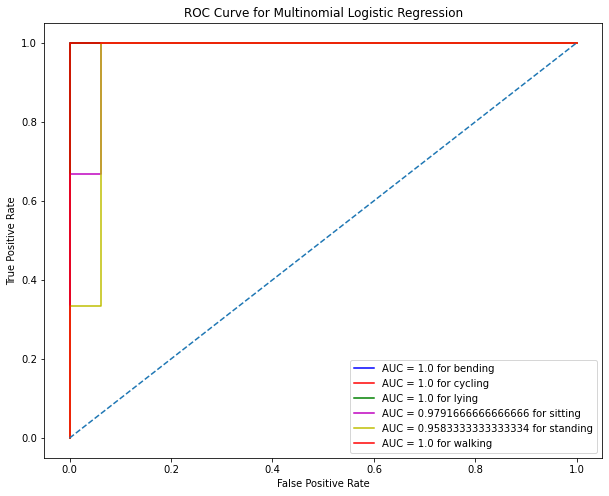

In [49]:
# Compute the ROC curve and area, using OVR technique.
y_test_l1_mc = label_binarize(y_test_l1_mc, classes=[1, 2, 3, 4, 5, 6])

y_score_mc = lr_l1_mc_opt.predict_proba(X_test_l1_mc)

plt.figure(figsize=(10,8))
# For bending
fpr_b, tpr_b, _  = roc_curve(y_test_l1_mc[:, 0], y_score_mc[:, 0])
roc_auc_b = auc(fpr_b, tpr_b)
plt.plot(fpr_b, tpr_b, color= 'b', label=f"AUC = {roc_auc_b} for bending")
# For cycling
fpr_c, tpr_c, _  = roc_curve(y_test_l1_mc[:, 1], y_score_mc[:, 1])
roc_auc_c = auc(fpr_c, tpr_c)
plt.plot(fpr_c, tpr_c, color= 'r', label=f"AUC = {roc_auc_c} for cycling")
# For lying
fpr_l, tpr_l, _  = roc_curve(y_test_l1_mc[:, 2], y_score_mc[:, 2])
roc_auc_l = auc(fpr_l, tpr_l)
plt.plot(fpr_l, tpr_l, color= 'g', label=f"AUC = {roc_auc_l} for lying")
# For sitting
fpr_si, tpr_si, _  = roc_curve(y_test_l1_mc[:, 3], y_score_mc[:, 3])
roc_auc_si = auc(fpr_si, tpr_si)
plt.plot(fpr_si, tpr_si, color= 'm', label=f"AUC = {roc_auc_si} for sitting")
# For standing
fpr_st, tpr_st, _  = roc_curve(y_test_l1_mc[:, 4], y_score_mc[:, 4])
roc_auc_st = auc(fpr_st, tpr_st)
plt.plot(fpr_st, tpr_st, color= 'y', label=f"AUC = {roc_auc_st} for standing")
# For walking
fpr_w, tpr_w, _  = roc_curve(y_test_l1_mc[:, 5], y_score_mc[:, 5])
roc_auc_w = auc(fpr_w, tpr_w)
plt.plot(fpr_w, tpr_w, color= 'r', label=f"AUC = {roc_auc_w} for walking")

plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for Multinomial Logistic Regression")
plt.legend()
plt.show()

<b>2bii) Repeat 2ci) using Naive Bayes' classifer. Use both Gaussian and Multinomial priors and compare results.</b>

In [50]:
mc_test_df = {}

for l in range(1, 21):
    broken_time = []
    # Propagate the 69 instances of evenly split time series training data in a dictionary.
    for i in range(len(test)):
        broken_time.append(break_time_series(test[i], l))

    # Extract the mean, median, and standard deviation from the each time series.
    mc_test_df[l] = multiclass_extract_features_dataframe(broken_time, l, [1, 2, 3, 4, 5, 6], train=False)

# Check the extracted time-domain features.
print(len(mc_test_df))
print(mc_test_df[1].shape, mc_test_df[5].shape, mc_test_df[10].shape, mc_test_df[15].shape, mc_test_df[20].shape)

20
(19, 19) (19, 91) (19, 181) (19, 271) (19, 361)


Part 1: Gaussian NB

In [51]:
# Select the best l for Gaussian NB.
gnb_dict = {}

for l in range(1, 21):
    X_train_gnb = mc_train_df[l].drop(['type'], axis=1)
    y_train_gnb = mc_train_df[l]['type']
    X_test_gnb = mc_test_df[l].drop(['type'], axis=1)
    y_test_gnb = mc_test_df[l]['type']
    gnb = GaussianNB()
    gnb.fit(X_train_gnb, y_train_gnb)
    y_hat_gnb = gnb.predict(X_test_gnb)
    gnb_dict[l] = accuracy_score(y_test_gnb, y_hat_gnb)

print(gnb_dict)

for key, val in gnb_dict.items():
 # Find the best number of splits for time series.
    max_val = max(gnb_dict.values())
    max_key = []
    for key, val in gnb_dict.items():
        if val == max_val:
            max_key.append(key)
    
print(f"All of the following splits has the good accuracy score: {max_key}.")
print(f"Choosing the smallest l from the list, splitting data into {max(gnb_dict, key=gnb_dict.get)} has maximum mean_test_score at {max_val}.")
l_opt_gnb = max_key[0]

{1: 0.8947368421052632, 2: 0.8421052631578947, 3: 0.8947368421052632, 4: 0.8947368421052632, 5: 0.8947368421052632, 6: 0.8947368421052632, 7: 0.8421052631578947, 8: 0.8421052631578947, 9: 0.8421052631578947, 10: 0.8947368421052632, 11: 0.8421052631578947, 12: 0.8421052631578947, 13: 0.8421052631578947, 14: 0.8947368421052632, 15: 0.8421052631578947, 16: 0.8421052631578947, 17: 0.8421052631578947, 18: 0.8421052631578947, 19: 0.8421052631578947, 20: 0.8421052631578947}
All of the following splits has the good accuracy score: [1, 3, 4, 5, 6, 10, 14].
Choosing the smallest l from the list, splitting data into 1 has maximum mean_test_score at 0.8947368421052632.


In [52]:
# Train and test Gaussian NB on optimal l.

X_train_gnb_opt = mc_train_df[l_opt_gnb].drop(['type'], axis=1)
y_train_gnb_opt = mc_train_df[l_opt_gnb]['type']
X_test_gnb_opt = mc_test_df[l_opt_gnb].drop(['type'], axis=1)
y_test_gnb_opt = mc_test_df[l_opt_gnb]['type']

gnb = GaussianNB()
gnb.fit(X_train_gnb_opt, y_train_gnb_opt)
y_hat_gnb = gnb.predict(X_test_gnb_opt)
test_accu_gnb = accuracy_score(y_test_gnb_opt, y_hat_gnb)
print(f"Test error: {1- test_accu_gnb}")

Test error: 0.10526315789473684


In [53]:
# Confusion matrix
multiclass_gnb = np.array(confusion_matrix(y_test_gnb_opt, y_hat_gnb))
mc_cm_gnb = pd.DataFrame(multiclass_gnb, index=['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking'], 
                    columns=['pred_bending', 'pred_cycling', 'pred_lying', 'pred_sitting', 'pred_standing', 'pred_walking'])
mc_cm_gnb

pred_bending  pred_cycling  pred_lying  pred_sitting  pred_standing  \
bending              4             0           0             0              0   
cycling              0             3           0             0              0   
lying                0             0           3             0              0   
sitting              0             0           0             3              0   
standing             0             0           0             2              1   
walking              0             0           0             0              0   

          pred_walking  
bending              0  
cycling              0  
lying                0  
sitting              0  
standing             0  
walking              3

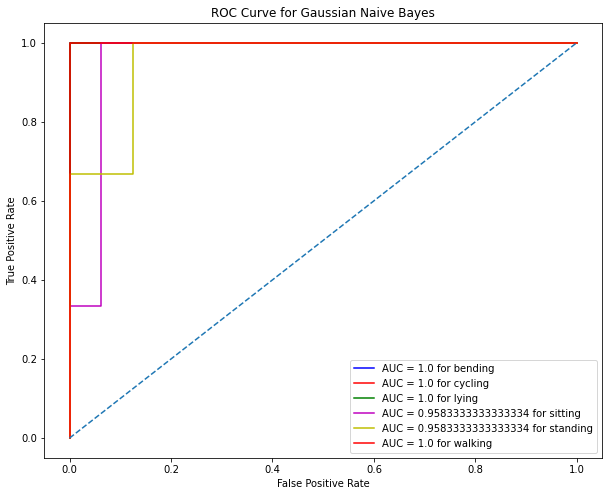

In [54]:
# Compute the ROC curve and area, using OVR technique.
y_test_gnb_opt = label_binarize(y_test_gnb_opt, classes=[1, 2, 3, 4, 5, 6])

y_score_gnb = gnb.predict_proba(X_test_gnb_opt)

plt.figure(figsize=(10,8))
# For bending
fpr_b, tpr_b, _  = roc_curve(y_test_gnb_opt[:, 0], y_score_gnb[:, 0])
roc_auc_b = auc(fpr_b, tpr_b)
plt.plot(fpr_b, tpr_b, color= 'b', label=f"AUC = {roc_auc_b} for bending")
# For cycling
fpr_c, tpr_c, _  = roc_curve(y_test_gnb_opt[:, 1], y_score_gnb[:, 1])
roc_auc_c = auc(fpr_c, tpr_c)
plt.plot(fpr_c, tpr_c, color= 'r', label=f"AUC = {roc_auc_c} for cycling")
# For lying
fpr_l, tpr_l, _  = roc_curve(y_test_gnb_opt[:, 2], y_score_gnb[:, 2])
roc_auc_l = auc(fpr_l, tpr_l)
plt.plot(fpr_l, tpr_l, color= 'g', label=f"AUC = {roc_auc_l} for lying")
# For sitting
fpr_si, tpr_si, _  = roc_curve(y_test_gnb_opt[:, 3], y_score_gnb[:, 3])
roc_auc_si = auc(fpr_si, tpr_si)
plt.plot(fpr_si, tpr_si, color= 'm', label=f"AUC = {roc_auc_si} for sitting")
# For standing
fpr_st, tpr_st, _  = roc_curve(y_test_gnb_opt[:, 4], y_score_gnb[:, 4])
roc_auc_st = auc(fpr_st, tpr_st)
plt.plot(fpr_st, tpr_st, color= 'y', label=f"AUC = {roc_auc_st} for standing")
# For walking
fpr_w, tpr_w, _  = roc_curve(y_test_gnb_opt[:, 5], y_score_gnb[:, 5])
roc_auc_w = auc(fpr_w, tpr_w)
plt.plot(fpr_w, tpr_w, color= 'r', label=f"AUC = {roc_auc_w} for walking")

plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for Gaussian Naive Bayes")
plt.legend()
plt.show()

Part 2: Multinomial NB

In [55]:
# Select the best l for Gaussian NB.
mnb_dict = {}

for l in range(1, 21):
    X_train_mnb = mc_train_df[l].drop(['type'], axis=1)
    y_train_mnb = mc_train_df[l]['type']
    X_test_mnb = mc_test_df[l].drop(['type'], axis=1)
    y_test_mnb = mc_test_df[l]['type']
    mnb = MultinomialNB()
    mnb.fit(X_train_mnb, y_train_mnb)
    y_hat_mnb = mnb.predict(X_test_mnb)
    mnb_dict[l] = accuracy_score(y_test_mnb, y_hat_mnb)

print(mnb_dict)

for key, val in mnb_dict.items():
 # Find the best number of splits for time series.
    max_val = max(mnb_dict.values())
    max_key = []
    for key, val in mnb_dict.items():
        if val == max_val:
            max_key.append(key)
    
print(f"All of the following splits has the good accuracy score: {max_key}.")
print(f"Choosing the smallest l from the list, splitting data into {max(mnb_dict, key=mnb_dict.get)} has maximum mean_test_score at {max_val}.")
l_opt_mnb = max_key[0]

{1: 0.8947368421052632, 2: 0.8947368421052632, 3: 0.9473684210526315, 4: 0.8947368421052632, 5: 0.8947368421052632, 6: 0.8947368421052632, 7: 0.8947368421052632, 8: 0.9473684210526315, 9: 0.8947368421052632, 10: 0.9473684210526315, 11: 0.9473684210526315, 12: 0.9473684210526315, 13: 0.9473684210526315, 14: 0.9473684210526315, 15: 0.9473684210526315, 16: 0.9473684210526315, 17: 0.9473684210526315, 18: 0.9473684210526315, 19: 0.9473684210526315, 20: 0.9473684210526315}
All of the following splits has the good accuracy score: [3, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20].
Choosing the smallest l from the list, splitting data into 3 has maximum mean_test_score at 0.9473684210526315.


In [56]:
# Train and test Multinomial NB on optimal l.

X_train_mnb_opt = mc_train_df[l_opt_mnb].drop(['type'], axis=1)
y_train_mnb_opt = mc_train_df[l_opt_mnb]['type']
X_test_mnb_opt = mc_test_df[l_opt_mnb].drop(['type'], axis=1)
y_test_mnb_opt = mc_test_df[l_opt_mnb]['type']

mnb = MultinomialNB()
mnb.fit(X_train_mnb_opt, y_train_mnb_opt)
y_hat_mnb = mnb.predict(X_test_mnb_opt)
test_accu_mnb = accuracy_score(y_test_mnb_opt, y_hat_mnb)
print(f"Test error: {1- test_accu_mnb}")

Test error: 0.052631578947368474


In [57]:
# Confusion matrix
multiclass_mnb = np.array(confusion_matrix(y_test_mnb_opt, y_hat_mnb))
mc_cm_mnb = pd.DataFrame(multiclass_mnb, index=['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking'], 
                    columns=['pred_bending', 'pred_cycling', 'pred_lying', 'pred_sitting', 'pred_standing', 'pred_walking'])
mc_cm_mnb

pred_bending  pred_cycling  pred_lying  pred_sitting  pred_standing  \
bending              4             0           0             0              0   
cycling              0             3           0             0              0   
lying                0             0           3             0              0   
sitting              0             0           0             2              1   
standing             0             0           0             0              3   
walking              0             0           0             0              0   

          pred_walking  
bending              0  
cycling              0  
lying                0  
sitting              0  
standing             0  
walking              3

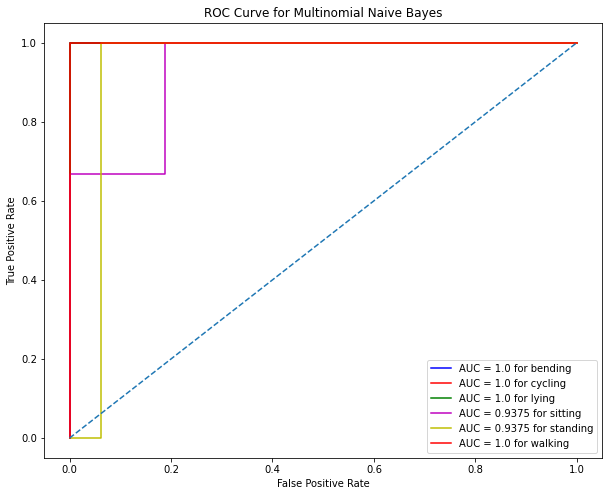

In [58]:
# Compute the ROC curve and area, using OVR technique.
y_test_mnb_opt = label_binarize(y_test_mnb_opt, classes=[1, 2, 3, 4, 5, 6])

y_score_mnb = mnb.predict_proba(X_test_mnb_opt)

plt.figure(figsize=(10,8))

# For bending
fpr_b, tpr_b, _  = roc_curve(y_test_mnb_opt[:, 0], y_score_mnb[:, 0])
roc_auc_b = auc(fpr_b, tpr_b)
plt.plot(fpr_b, tpr_b, color= 'b', label=f"AUC = {roc_auc_b} for bending")

# For cycling
fpr_c, tpr_c, _  = roc_curve(y_test_mnb_opt[:, 1], y_score_mnb[:, 1])
roc_auc_c = auc(fpr_c, tpr_c)
plt.plot(fpr_c, tpr_c, color= 'r', label=f"AUC = {roc_auc_c} for cycling")

# For lying
fpr_l, tpr_l, _  = roc_curve(y_test_mnb_opt[:, 2], y_score_mnb[:, 2])
roc_auc_l = auc(fpr_l, tpr_l)
plt.plot(fpr_l, tpr_l, color= 'g', label=f"AUC = {roc_auc_l} for lying")

# For sitting
fpr_si, tpr_si, _  = roc_curve(y_test_mnb_opt[:, 3], y_score_mnb[:, 3])
roc_auc_si = auc(fpr_si, tpr_si)
plt.plot(fpr_si, tpr_si, color= 'm', label=f"AUC = {roc_auc_si} for sitting")

# For standing
fpr_st, tpr_st, _  = roc_curve(y_test_mnb_opt[:, 4], y_score_mnb[:, 4])
roc_auc_st = auc(fpr_st, tpr_st)
plt.plot(fpr_st, tpr_st, color= 'y', label=f"AUC = {roc_auc_st} for standing")

# For walking
fpr_w, tpr_w, _  = roc_curve(y_test_mnb_opt[:, 5], y_score_mnb[:, 5])
roc_auc_w = auc(fpr_w, tpr_w)
plt.plot(fpr_w, tpr_w, color= 'r', label=f"AUC = {roc_auc_w} for walking")

plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for Multinomial Naive Bayes")
plt.legend()
plt.show()

<b>2biii) Which method is better for multi-class classification in this problem?</b>

In [59]:
print(f"Based on the confusion matrices, the Naive Bayes have a better classification success when compared to Logistic Regression. Among the Naive Bayes, the Multinomial model is better than the Gaussian model. The error rate reflects the observation from the confusion matrix, the error rate for Multinomial Logistic Regression is {1 - test_accu_l1_mc}, the error rate for Gaussian Naive Bayes is {1- test_accu_gnb}, and the error rate for Multinomial Naive Bayes is {1- test_accu_mnb}.")

Based on the confusion matrices, the Naive Bayes have a better classification success when compared to Logistic Regression. Among the Naive Bayes, the Multinomial model is better than the Gaussian model. The error rate reflects the observation from the confusion matrix, the error rate for Multinomial Logistic Regression is 0.1578947368421053, the error rate for Gaussian Naive Bayes is 0.10526315789473684, and the error rate for Multinomial Naive Bayes is 0.052631578947368474.


<b>3. ISLR 4.8.3 This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class- specific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature.
Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, X ∼ N(μk,σk2). Recall that the density function for the one-dimensional normal distribution is given in (4.16). Prove that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic.</b>

Ans: Please see the PDF document with scanned answer.

<b>4. ISLR 4.8.7 Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was X = 10, while the mean for those that didn’t was X = 0. In addition, the variance of X for these two sets of companies was σˆ2 = 36. Finally, 80% of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.
</b>

Ans: Please see the PDF document with scanned answer.

<b>References:</b><br>
1. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV<br>
2. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br>
3. https://www.statology.org/pandas-data-cast-to-numpy-dtype-of-object-check-input-data-with-np-asarraydata/<br>
4. https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics<br>
5. https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/<br>
6. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html<br>
7. https://www.datasklr.com/logistic-regression/multinomial-logistic-regression<br>
8. https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py<br>